# Statistics for CBDC Sentence Dataset

In [ ]:
# ============================================================
# Descriptive Statistics for CBDC Sentence Dataset
# ============================================================
# Input schema expected: url, cbdc_sentence, title, description, date,
#                        author, affiliation, position, country
# ------------------------------------------------------------

# ========== TASK 0. Imports & Paths =========================================
import os, re, math, json
import numpy as np
import pandas as pd
from collections import Counter

IN_FILE  = "cbdc-dataset-final.csv"
OUT_DIR  = "results"                     # <-- per request
os.makedirs(OUT_DIR, exist_ok=True)

# ========== TASK 1. Load & Basic Hygiene ====================================
df = pd.read_csv(IN_FILE)

# Standardize text columns
for col in ["cbdc_sentence","title","description","author","affiliation","position","country","url"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().replace({"nan": np.nan, "None": np.nan})
        df[col] = df[col].str.replace(r"\s+", " ", regex=True)

# Dates & calendar cuts
df["date"]    = pd.to_datetime(df["date"], errors="coerce", infer_datetime_format=True)
df["year"]    = df["date"].dt.year
df["month"]   = df["date"].dt.month
df["quarter"] = df["date"].dt.to_period("Q").astype(str)

# Sentence length features
df["tokens"] = df["cbdc_sentence"].fillna("").str.split().str.len()
df["chars"]  = df["cbdc_sentence"].fillna("").str.len()

# ========== TASK 2. Overview & Missingness ==================================
overview = pd.DataFrame({
    "rows (sentences)":            [len(df)],
    "unique URLs (speeches)":      [df["url"].nunique()],
    "date coverage (min→max)":     [f"{df['date'].min():%Y-%m-%d} → {df['date'].max():%Y-%m-%d}"],
    "unique authors":              [df["author"].nunique(dropna=True)],
    "unique affiliations":         [df["affiliation"].nunique(dropna=True)],
    "unique positions":            [df["position"].nunique(dropna=True)],
    "unique countries":            [df["country"].nunique(dropna=True)],
    "median tokens / sentence":    [int(df["tokens"].median())],
    "p90 tokens / sentence":       [int(df["tokens"].quantile(0.90))],
}).T.reset_index().rename(columns={"index": "metric", 0: "value"})

missing = (df[["title","description","date","author","affiliation","position","country"]]
           .isna().mean().mul(100).round(1)
           .rename("missing_percent").reset_index()
           .rename(columns={"index":"column"}))

# ========== TASK 3. Time Series (Year / Quarter) ============================
by_year = (df.groupby("year")
             .agg(sentences=("url","count"),
                  speeches=("url","nunique"))
             .reset_index()
             .sort_values("year"))

by_quarter = (df.groupby("quarter")
                .agg(sentences=("url","count"),
                     speeches=("url","nunique"))
                .reset_index()
                .sort_values("quarter"))

# ========== TASK 4. Entity Frequencies ======================================
def freq_table(series, k=20, dropna=True, name=None):
    s = series if not dropna else series.dropna()
    counts = s.value_counts()
    out = (pd.DataFrame({"count": counts, "share_%": (counts / counts.sum() * 100).round(2)})
           .reset_index()
           .rename(columns={"index": name or series.name}))
    return out.head(k)

top_authors = (df.groupby("author")
                 .agg(sentences=("url","count"),
                      speeches=("url","nunique"),
                      first_year=("year","min"),
                      last_year=("year","max"),
                      avg_tokens=("tokens","mean"))
                 .reset_index()
                 .sort_values(["sentences","speeches"], ascending=False)
                 .head(25))
top_authors["avg_tokens"] = top_authors["avg_tokens"].round(1)

top_affiliations = (df.groupby("affiliation")
                     .agg(sentences=("url","count"),
                          speeches=("url","nunique"),
                          countries=("country", pd.Series.nunique))
                     .reset_index()
                     .sort_values(["sentences","speeches"], ascending=False)
                     .head(25))

top_positions = freq_table(df["position"], k=25, name="position", dropna=True)
top_countries = freq_table(df["country"], k=25, name="country", dropna=True)

# ========== TASK 5. Affiliation × Country Crosstab (SAFE) ===================
# Avoid KeyError from mis-using row labels as column names in sort_values
tmp = df.copy()
tmp["country"] = tmp["country"].fillna("Unknown")
ct = pd.crosstab(tmp["affiliation"], tmp["country"])

# Sort rows by totals; sort columns by totals
ct["__row_total__"] = ct.sum(axis=1)
ct = ct.sort_values("__row_total__", ascending=False)
col_order = ct.drop(columns="__row_total__").sum(axis=0).sort_values(ascending=False).index
ct = ct.loc[:, list(col_order) + ["__row_total__"]]

N = 20
aff_country_top = ct.head(N).reset_index().rename(columns={"affiliation":"Affiliation","__row_total__":"Total"})

# ========== TASK 6. Sentence-Length Distributions ===========================
def describe_length(col):
    return (df[col].describe(percentiles=[.1,.25,.5,.75,.9,.95,.99])
              .round(2).to_frame(name=col).reset_index()
              .rename(columns={"index":"stat"}))

len_tokens = describe_length("tokens")
len_chars  = describe_length("chars")

# ========== TASK 7. N-gram Summaries (Uni/Bi/Tri) ===========================
STOP = {
    "a","an","the","and","or","for","of","to","in","on","at","with","by","from","as","that","this",
    "is","are","was","were","be","been","being","it","its","into","than","then","so","such","which",
    "will","would","should","could","may","might","can","cannot","not","no","do","does","did","doing",
    "we","our","us","you","your","they","their","them","i","he","she","his","her","him","mr","mrs","ms",
    "central","bank","digital","currency","cbdc","banks","monetary","policy","speech","hong","kong",
    "china","people","banking","system","economy","financial"
}

def tokenize(s: str):
    return re.findall(r"[A-Za-z']+", str(s).lower())

def top_ngrams(series, n=1, top=50):
    counter = Counter()
    for s in series.dropna():
        toks = [t for t in tokenize(s) if t not in STOP]
        if n == 1:
            counter.update(toks)
        else:
            if len(toks) >= n:
                grams = zip(*[toks[i:] for i in range(n)])
                counter.update((" ".join(g),) for g in grams)
    dfc = (pd.DataFrame(counter.most_common(top), columns=[f"{n}-gram","count"])
             .assign(**{"share_%": lambda d: (d["count"]/d["count"].sum()*100).round(2)}))
    return dfc

top_unigrams = top_ngrams(df["cbdc_sentence"], n=1, top=50)
top_bigrams  = top_ngrams(df["cbdc_sentence"], n=2, top=50)
top_trigrams = top_ngrams(df["cbdc_sentence"], n=3, top=50)

# ========== TASK 8. Country × Year Matrix ===================================
country_year = (pd.crosstab(df["country"], df["year"])
                .loc[lambda t: t.sum(axis=1).sort_values(ascending=False).index]
                .reset_index())

# ========== TASK 9. Persist Tables (CSV + Excel) ============================
tables = {
    "00_overview.csv":                 overview,
    "01_missingness.csv":              missing,
    "02_by_year.csv":                  by_year,
    "03_by_quarter.csv":               by_quarter,
    "04_top_authors.csv":              top_authors,
    "05_top_affiliations.csv":         top_affiliations,
    "06_top_positions.csv":            top_positions,
    "07_top_countries.csv":            top_countries,
    "08_affiliation_x_country.csv":    aff_country_top,
    "09_len_tokens.csv":               len_tokens,
    "10_len_chars.csv":                len_chars,
    "11_top_unigrams.csv":             top_unigrams,
    "12_top_bigrams.csv":              top_bigrams,
    "13_top_trigrams.csv":             top_trigrams,
    "14_country_year_matrix.csv":      country_year,
}

for fname, frame in tables.items():
    frame.to_csv(os.path.join(OUT_DIR, fname), index=False)

# Also bundle as a single Excel workbook (if openpyxl available)
try:
    import openpyxl
    with pd.ExcelWriter(os.path.join(OUT_DIR, "cbdc_descriptives.xlsx"), engine="openpyxl") as xl:
        for sheet, frame in {
            "Overview": overview,
            "Missingness": missing,
            "ByYear": by_year,
            "ByQuarter": by_quarter,
            "TopAuthors": top_authors,
            "TopAffiliations": top_affiliations,
            "TopPositions": top_positions,
            "TopCountries": top_countries,
            "Affiliations×Country": aff_country_top,
            "LenTokens": len_tokens,
            "LenChars": len_chars,
            "Unigrams": top_unigrams,
            "Bigrams": top_bigrams,
            "Trigrams": top_trigrams,
            "Country×Year": country_year,
        }.items():
            frame.to_excel(xl, sheet_name=sheet, index=False)
    print(f"📒 Wrote Excel workbook → {os.path.join(OUT_DIR, 'cbdc_descriptives.xlsx')}")
except Exception as e:
    print("Excel export skipped:", e)

# ============================
# Top Authors (horizontal bar)
# ============================
import os
import pandas as pd
import matplotlib.pyplot as plt

OUT_DIR = "results"
os.makedirs(OUT_DIR, exist_ok=True)

# --- build an author list that splits multi-author rows ---
# assumes your full dataset is already loaded in `df`
auth_col = "author"
text_id  = "url"   # counts based on sentences; keep as 'url' if you want speeches use nunique later

# split on semicolon, strip whitespace, drop empties, and explode
auth_series = (df[auth_col]
               .dropna()
               .astype(str)
               .str.split(";")
               .explode()
               .str.strip())
auth_series = auth_series[auth_series.ne("")]

# count sentences per author
topk = 15  # change to 20/25 if you want a longer bar chart
author_counts = (auth_series
                 .to_frame(name="author")
                 .assign(sentences=1)
                 .groupby("author", as_index=False)["sentences"].sum()
                 .sort_values("sentences", ascending=False)
                 .head(topk))
# --- plot (horizontal bar) ---
fig = plt.figure(figsize=(7, 5))
plt.barh(author_counts["author"][::-1], author_counts["sentences"][::-1])
plt.xlabel("Sentences")
plt.title("Top Authors by CBDC Mentions")
plt.tight_layout()

out_path = os.path.join(OUT_DIR, "top_authors.svg")
plt.savefig(out_path, format="svg")
plt.close(fig)

print(f"✅ Saved: {out_path}")


# ============================
# Top Authors (horizontal bar) by speeches
# ============================
import os
import pandas as pd
import matplotlib.pyplot as plt

OUT_DIR = "results"
os.makedirs(OUT_DIR, exist_ok=True)

# --- build an author list that splits multi-author rows ---
# assumes your full dataset is already loaded in `df`
auth_col = "author"
text_id  = "url"   # counts based on sentences; keep as 'url' if you want speeches use nunique later

# split on semicolon, strip whitespace, drop empties, and explode
auth_series = (df[auth_col]
               .dropna()
               .astype(str)
               .str.split(";")
               .explode()
               .str.strip())
auth_series = auth_series[auth_series.ne("")]

#unique speeches per author
tmp = (df.assign(author_list=df["author"].fillna("").astype(str).str.split(";"))
          .explode("author_list"))
author_counts = (tmp.assign(author_list=tmp["author_list"].str.strip())
                      .query("author_list != ''")
                      .groupby("author_list")["url"].nunique()
                      .reset_index(name="speeches")
                      .sort_values("speeches", ascending=False)
                      .head(topk)
                 .rename(columns={"author_list":"author", "speeches":"sentences"}))

# --- plot (horizontal bar) ---
fig = plt.figure(figsize=(7, 5))
plt.barh(author_counts["author"][::-1], author_counts["sentences"][::-1])
plt.xlabel("Speeches")
plt.title("Top Authors by CBDC Mentions")
plt.tight_layout()

out_path = os.path.join(OUT_DIR, "top_authors_by_speeches.svg")
plt.savefig(out_path, format="svg")
plt.close(fig)

print(f"✅ Saved: {out_path}")



# ========== TASK 10. Figures (SVG) ==========================================
import matplotlib.pyplot as plt

# Time series (sentences & speeches per year)
fig = plt.figure()
plt.plot(by_year["year"], by_year["sentences"], label="Sentences")
plt.plot(by_year["year"], by_year["speeches"],  label="Speeches")
plt.xlabel("Year"); plt.ylabel("Count"); plt.title("CBDC Mentions Over Time"); plt.legend()
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "timeseries_year.svg")); plt.close(fig)

# Top affiliations (bar, top 15)
ta15 = top_affiliations.head(15)
fig = plt.figure()
plt.barh(ta15["affiliation"][::-1], ta15["sentences"][::-1])
plt.xlabel("Sentences"); plt.title("Top Affiliations by CBDC Mentions")
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "top_affiliations.svg")); plt.close(fig)

# Top countries (bar, top 15)
tc15 = top_countries.head(15)
fig = plt.figure()
plt.barh(tc15["country"][::-1], tc15["count"][::-1])
plt.xlabel("Sentences"); plt.title("Top Countries by CBDC Mentions")
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "top_countries.svg")); plt.close(fig)

# Affiliation × Country heatmap (top N rows; columns already sorted by totals)
heat = ct.drop(columns="__row_total__").head(N)
fig = plt.figure(figsize=(10, 6))
plt.imshow(heat.values, aspect="auto")
plt.yticks(range(heat.shape[0]), heat.index)
plt.xticks(range(heat.shape[1]), heat.columns, rotation=45, ha="right")
plt.title("Affiliation × Country (Top 20 affiliations by CBDC mentions)")
plt.colorbar(label="Sentences")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "affiliation_country_heatmap.svg"))
plt.close(fig)

print(f"✅ Descriptives complete. Tables & figures saved in: {OUT_DIR}")

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17016\3833511645.py:28: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["date"]    = pd.to_datetime(df["date"], errors="coerce", infer_datetime_format=True)


📒 Wrote Excel workbook → results\cbdc_descriptives.xlsx
✅ Saved: results\top_authors.svg
✅ Descriptives complete. Tables & figures saved in: results


# CBDC Sentence Classification Pipeline

Applied four **domain-specialized BERT models** to classify BIS speech sentences on Central Bank Digital Currencies (CBDCs).
The script runs in **Google Colab with GPU**, loads the input dataset, performs inference, and saves enriched results.

## Models Used
1. **CBDC-Type** → `Retail CBDC`, `Wholesale CBDC`, `General/Unspecified`
2. **CBDC-Stance** → `Pro-CBDC`, `Wait-and-See`, `Anti-CBDC`
3. **CBDC-Sentiment** → `Positive`, `Neutral`, `Negative`
4. **CBDC-Discourse** → `Feature`, `Risk-Benefit`, `Process`

Each model returns the **predicted label** and **confidence score**.

In [ ]:
# =========================
# Colab setup & dependencies
# =========================
# !pip -q install -U "transformers>=4.41" "huggingface_hub>=0.23" accelerate pandas

import os, getpass, datetime as dt
import pandas as pd
import torch
from google.colab import drive
from huggingface_hub import login
from transformers import pipeline

# -------------------------
# 1) Mount Google Drive
# -------------------------
drive.mount('/content/drive')

# -------------------------
# 2) Paths & filenames
# -------------------------
DATA_DIR   = "/content/drive/MyDrive/cbdc-analysis"
CSV_FILE   = "cbdc-dataset-final.csv"      # your file
SENT_COL   = "cbdc_sentence"               # column containing sentences
OUT_FILE   = f"cbdc-dataset-predictions.csv"

in_path  = os.path.join(DATA_DIR, CSV_FILE)
out_path = os.path.join(DATA_DIR, OUT_FILE)

# -------------------------
# 3) Hugging Face login
# -------------------------
HF_TOKEN = getpass.getpass("HF Token): ")
login(token=HF_TOKEN)

# -------------------------
# 4) Load data (robust to comma or tab)
# -------------------------
def load_df(path):
    try:
        # Let pandas sniff the delimiter
        df = pd.read_csv(path, sep=None, engine="python")
    except Exception:
        # Common fallback: tab-separated
        df = pd.read_csv(path, sep="\t")
    return df

df = load_df(in_path)
assert SENT_COL in df.columns, f"Column '{SENT_COL}' not found. Available: {list(df.columns)}"
texts = df[SENT_COL].astype(str).fillna("").tolist()
print(f"Loaded {len(texts)} sentences from: {in_path}")

# -------------------------
# 5) Models to run
# -------------------------
MODEL_IDS = {
    "Type":      "bilalzafar/CBDC-Type",       # Retail / Wholesale / General
    "Stance":    "bilalzafar/CBDC-Stance",     # Pro / Wait-and-See / Anti
    "Sentiment": "bilalzafar/CBDC-Sentiment",  # negative / neutral / positive
    "Discourse": "bilalzafar/CBDC-Discourse",  # Feature / Risk-Benefit / Process
}

# Prefer GPU if available
DEVICE = 0 if torch.cuda.is_available() else -1
print("Using device:", "GPU" if DEVICE == 0 else "CPU")

# Optional: half precision on GPU for speed
model_kwargs = {"torch_dtype": torch.float16} if DEVICE == 0 else {}

# -------------------------
# 6) Build pipelines
# -------------------------
pipes = {}
for name, repo in MODEL_IDS.items():
    print(f"Loading: {name} -> {repo}")
    pipes[name] = pipeline(
        task="text-classification",
        model=repo,
        device=DEVICE,
        model_kwargs=model_kwargs
    )

# -------------------------
# 7) Batched inference helper
# -------------------------
def predict_top(pipe, batch_texts, batch_size=64, max_length=320):
    """
    Returns two lists (labels, scores) for a list of texts using a HF pipeline.
    """
    labels, scores = [], []
    for i in range(0, len(batch_texts), batch_size):
        chunk = batch_texts[i:i+batch_size]
        outputs = pipe(chunk, truncation=True, max_length=max_length, batch_size=batch_size)
        # outputs is a list of dicts like {'label': 'Retail CBDC', 'score': 0.998}
        for o in outputs:
            labels.append(o["label"])
            scores.append(float(o["score"]))
    return labels, scores

# -------------------------
# 8) Run all four models
# -------------------------
results = {}
for name, p in pipes.items():
    print(f"Running predictions for: {name}")
    lbls, scs = predict_top(p, texts, batch_size=64, max_length=320)
    results[f"{name}_Label"] = lbls
    results[f"{name}_Score"] = scs

# -------------------------
# 9) Merge & save
# -------------------------
pred_df = pd.DataFrame(results)
out_df = pd.concat([df.reset_index(drop=True), pred_df], axis=1)

# Preview a few rows
display(out_df[[SENT_COL,
                "Type_Label","Type_Score",
                "Stance_Label","Stance_Score",
                "Sentiment_Label","Sentiment_Score",
                "Discourse_Label","Discourse_Score"]].head(10))

# Save to Drive
out_df.to_csv(out_path, index=False)
print(f"\nSaved predictions to: {out_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
HF Token): ··········
Loaded 5376 sentences from: /content/drive/MyDrive/cbdc-analysis/cbdc-dataset-final.csv
Using device: GPU
Loading: Type -> bilalzafar/CBDC-Type


Device set to use cuda:0


Loading: Stance -> bilalzafar/CBDC-Stance


Device set to use cuda:0


Loading: Sentiment -> bilalzafar/CBDC-Sentiment


Device set to use cuda:0


Loading: Discourse -> bilalzafar/CBDC-Discourse


Device set to use cuda:0


Running predictions for: Type
Running predictions for: Stance
Running predictions for: Sentiment
Running predictions for: Discourse


,cbdc_sentence,Type_Label,Type_Score,Stance_Label,Stance_Score,Sentiment_Label,Sentiment_Score,Discourse_Label,Discourse_Score
0,"a ""central bank digital currency"" (cbdc) would...",Wholesale CBDC,0.996188,Wait-and-See,0.974996,neutral,0.977445,Feature,0.999242
1,and if a private-sector digital currency uses ...,General/Unspecified,0.890465,Wait-and-See,0.902239,neutral,0.910715,Feature,0.599473
2,"and, as i tried to explain earlier, a cbdc tha...",Retail CBDC,0.998955,Anti-CBDC,0.948519,negative,0.971240,Risk-Benefit,0.998474
3,"as far as its economic effects are concerned, ...",Retail CBDC,0.997053,Wait-and-See,0.983435,neutral,0.979650,Risk-Benefit,0.985957
4,as long as it's possible to hold something wit...,General/Unspecified,0.867670,Wait-and-See,0.917042,neutral,0.840400,Feature,0.998640
5,"barrdear, j and kumhof, m (2016), ""the macroec...",General/Unspecified,0.997969,Wait-and-See,0.979625,neutral,0.979549,Process,0.999236
6,ben broadbent: central banks and digital curre...,General/Unspecified,0.997384,Wait-and-See,0.975705,neutral,0.981172,Process,0.999203
7,"but as you widen that access, and the more clo...",Retail CBDC,0.998112,Wait-and-See,0.913568,negative,0.987450,Risk-Benefit,0.938904
8,central bank digital currency: who can bank at...,Retail CBDC,0.997253,Wait-and-See,0.984925,neutral,0.988997,Process,0.999160
9,"conversely, others see the distributed ledger ...",General/Unspecified,0.996235,Pro-CBDC,0.904902,positive,0.737670,Risk-Benefit,0.994623



Saved predictions to: /content/drive/MyDrive/cbdc-analysis/cbdc-dataset-predictions.csv


# CBDC Predictions: Analysis & Exports

In [ ]:
# =========================
# CBDC Predictions: Analysis & Exports
# =========================
# Requirements: pandas, numpy, matplotlib, scikit-learn (for n-grams)
# pip install -U pandas numpy matplotlib scikit-learn

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# -------------------------
# Config
# -------------------------
INPUT_FILE   = "cbdc-dataset-predictions.csv" 
OUTPUT_DIR   = Path("prediction_results")
SENT_COL     = "cbdc_sentence"
DATE_COL     = "date"
COUNTRY_COL  = "country"
AUTHOR_COL   = "author"
AFFIL_COL    = "affiliation"
TOP_N        = 20             # top items in bar charts / tables
LOW_CONF_THR = 0.60           # flag low-confidence predictions

OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

# -------------------------
# Helpers
# -------------------------
def save_csv(df, name):
    path = OUTPUT_DIR / f"{name}.csv"
    df.to_csv(path, index=False)
    print(f"Saved CSV: {path}")

def save_fig(fig, name):
    path = OUTPUT_DIR / f"{name}.svg"
    fig.savefig(path, format="svg", bbox_inches="tight", dpi=150)
    plt.close(fig)
    print(f"Saved SVG: {path}")

def parse_dates(series):
    # robust parse without deprecated infer_datetime_format
    d1 = pd.to_datetime(series, errors="coerce", dayfirst=False)
    mask = d1.isna()
    if mask.any():
        d2 = pd.to_datetime(series[mask], errors="coerce", dayfirst=True)
        d1.loc[mask] = d2
    return d1

def value_counts_df(series, normalize=False, top=None):
    """
    Return value counts as a DataFrame with consistent column names.
    """
    vc = series.value_counts(normalize=normalize, dropna=False)
    if top:
        vc = vc.head(top)
    colname = "count" if not normalize else "proportion"
    return vc.rename_axis(series.name or "value").reset_index(name=colname)

def barplot_counts(series, title, fname, top=TOP_N):
    counts = series.value_counts().head(top)
    fig, ax = plt.subplots(figsize=(8, 5))
    counts.sort_values().plot(kind="barh", ax=ax)
    ax.set_xlabel("Count")
    ax.set_ylabel("")
    ax.set_title(title)
    for i, v in enumerate(counts.sort_values().values):
        ax.text(v, i, f" {v}", va="center")
    save_fig(fig, fname)

def heatmap_table(ct, title, fname):
    fig, ax = plt.subplots(figsize=(1.1*ct.shape[1]+4, 1.1*ct.shape[0]+3))
    im = ax.imshow(ct.values, aspect="auto")
    ax.set_xticks(range(ct.shape[1])); ax.set_xticklabels(ct.columns, rotation=45, ha="right")
    ax.set_yticks(range(ct.shape[0])); ax.set_yticklabels(ct.index)
    ax.set_title(title)
    for i in range(ct.shape[0]):
        for j in range(ct.shape[1]):
            ax.text(j, i, f"{ct.values[i, j]:,.0f}", ha="center", va="center", fontsize=9, color="white" if im.cmap(im.norm(ct.values[i,j]))[0:3] < (0.5,0.5,0.5) else "black")
    fig.colorbar(im, ax=ax, label="Count")
    save_fig(fig, fname)

def score_hist(scores, title, fname, bins=25):
    fig, ax = plt.subplots(figsize=(7,4))
    ax.hist(scores.dropna(), bins=bins)
    ax.set_xlabel("Confidence score")
    ax.set_ylabel("Frequency")
    ax.set_title(title)
    save_fig(fig, fname)

def stacked_bar(pivot, title, fname):
    fig, ax = plt.subplots(figsize=(10,6))
    pivot.plot(kind="bar", stacked=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(pivot.index.name or "")
    ax.set_ylabel("Count")
    ax.legend(title=pivot.columns.name or "", bbox_to_anchor=(1.02, 1), loc="upper left")
    save_fig(fig, fname)

def top_ngrams_per_label(df, text_col, label_col, ngram_range=(1,2), top_k=20):
    # use a domain stoplist to avoid trivial tokens
    stop_words = set(CountVectorizer(stop_words="english").get_stop_words() or [])
    stop_words |= {"cbdc","cbdcs","central","bank","banks","digital","currency","currencies",
                   "centralbank","central-bank","centralbanks","euro","dollar","banking"}
    rows = []
    for label, d in df.groupby(label_col):
        corpus = d[text_col].dropna().astype(str).tolist()
        if not corpus:
            continue
        vec = CountVectorizer(stop_words=list(stop_words), ngram_range=ngram_range, min_df=2)
        X = vec.fit_transform(corpus)
        sums = np.asarray(X.sum(axis=0)).ravel()
        terms = np.array(vec.get_feature_names_out())
        order = np.argsort(-sums)[:top_k]
        for t, c in zip(terms[order], sums[order]):
            rows.append({label_col: label, "ngram": t, "count": int(c)})
    out = pd.DataFrame(rows).sort_values([label_col, "count"], ascending=[True, False])
    return out

# -------------------------
# Load data
# -------------------------
df = pd.read_csv(INPUT_FILE)
required_cols = [
    SENT_COL,
    "Type_Label","Type_Score",
    "Stance_Label","Stance_Score",
    "Sentiment_Label","Sentiment_Score",
    "Discourse_Label","Discourse_Score"
]
missing = [c for c in required_cols if c not in df.columns]
assert not missing, f"Missing required columns: {missing}"

# Optional metadata
for col in [DATE_COL, COUNTRY_COL, AUTHOR_COL, AFFIL_COL]:
    if col not in df.columns:
        df[col] = np.nan

# Parse dates & add time features
dates = parse_dates(df[DATE_COL])
df["year"]   = dates.dt.year
df["month"]  = dates.dt.month
df["quarter"] = dates.dt.quarter

# Strip label whitespace just in case
for p in ["Type","Stance","Sentiment","Discourse"]:
    df[f"{p}_Label"] = df[f"{p}_Label"].astype(str).str.strip()

# -------------------------
# 1) Global distributions
# -------------------------
for p in ["Type","Stance","Sentiment","Discourse"]:
    counts = value_counts_df(df[f"{p}_Label"])
    props  = value_counts_df(df[f"{p}_Label"], normalize=True)
    save_csv(counts, f"{p.lower()}_label_counts")
    save_csv(props,  f"{p.lower()}_label_proportions")
    barplot_counts(df[f"{p}_Label"], f"{p} — label distribution", f"{p.lower()}_label_distribution_bar")

# Score histograms
for p in ["Type","Stance","Sentiment","Discourse"]:
    score_hist(df[f"{p}_Score"], f"{p} — score distribution", f"{p.lower()}_score_hist")

# Low-confidence triage (per model)
low_conf_tables = []
for p in ["Type","Stance","Sentiment","Discourse"]:
    low = df[df[f"{p}_Score"] < LOW_CONF_THR].copy()
    low = low[[SENT_COL, f"{p}_Label", f"{p}_Score", "url", "title", DATE_COL, COUNTRY_COL, AUTHOR_COL]]
    save_csv(low, f"low_confidence_{p.lower()}_thr_{int(LOW_CONF_THR*100)}")
    low_conf_tables.append({"model": p, "low_conf_count": len(low), "share": len(low)/len(df)})

save_csv(pd.DataFrame(low_conf_tables), "low_confidence_summary")

# High-confidence exemplars per class (top 10 each)
for p in ["Type","Stance","Sentiment","Discourse"]:
    exemplars = []
    for label in df[f"{p}_Label"].dropna().unique():
        block = (
            df[df[f"{p}_Label"] == label]
            .sort_values(f"{p}_Score", ascending=False)
            .head(10)
            [[SENT_COL, f"{p}_Label", f"{p}_Score", "url", "title", DATE_COL, COUNTRY_COL, AUTHOR_COL]]
        )
        exemplars.append(block.assign(_label_group=label))
    if exemplars:
        out = pd.concat(exemplars, ignore_index=True)
        save_csv(out, f"exemplars_top10_per_label_{p.lower()}")

# -------------------------
# 2) Cross-model consistency
# -------------------------
# Type vs Discourse (e.g., which discourse categories dominate Retail vs Wholesale vs General)
ct_type_disc = pd.crosstab(df["Type_Label"], df["Discourse_Label"])
save_csv(ct_type_disc.reset_index(), "crosstab_type_by_discourse")
heatmap_table(ct_type_disc, "Type × Discourse (counts)", "heatmap_type_by_discourse")

# Stance vs Sentiment (correlation of stance and tone)
ct_stance_sent = pd.crosstab(df["Stance_Label"], df["Sentiment_Label"])
save_csv(ct_stance_sent.reset_index(), "crosstab_stance_by_sentiment")
heatmap_table(ct_stance_sent, "Stance × Sentiment (counts)", "heatmap_stance_by_sentiment")

# Type vs Stance
ct_type_stance = pd.crosstab(df["Type_Label"], df["Stance_Label"])
save_csv(ct_type_stance.reset_index(), "crosstab_type_by_stance")
heatmap_table(ct_type_stance, "Type × Stance (counts)", "heatmap_type_by_stance")

# -------------------------
# 3) Time trends
# -------------------------
# By year: Type distribution
by_year_type = df.pivot_table(index="year", columns="Type_Label", values=SENT_COL, aggfunc="count").fillna(0).astype(int)
by_year_type = by_year_type.sort_index()
save_csv(by_year_type.reset_index(), "yearly_counts_by_type")
stacked_bar(by_year_type, "Yearly counts by Type", "yearly_counts_by_type_stacked")

# By year: Discourse distribution
by_year_disc = df.pivot_table(index="year", columns="Discourse_Label", values=SENT_COL, aggfunc="count").fillna(0).astype(int)
by_year_disc = by_year_disc.sort_index()
save_csv(by_year_disc.reset_index(), "yearly_counts_by_discourse")
stacked_bar(by_year_disc, "Yearly counts by Discourse", "yearly_counts_by_discourse_stacked")

# -------------------------
# 4) Geography & authorship
# -------------------------
# Top countries overall and by Type
top_countries = (
    df[COUNTRY_COL].dropna().astype(str).str.strip().value_counts().head(TOP_N).rename_axis(COUNTRY_COL).reset_index(name="count")
)
save_csv(top_countries, "top_countries_overall")
barplot_counts(df[COUNTRY_COL].dropna().astype(str).str.strip(), "Top countries (overall)", "top_countries_overall_bar")

type_country = (
    df.groupby([COUNTRY_COL, "Type_Label"], dropna=True)[SENT_COL].count().reset_index(name="count")
)
# keep only top countries for a readable pivot/plot
type_country = type_country[type_country[COUNTRY_COL].isin(top_countries[COUNTRY_COL])]
pivot_tc = type_country.pivot(index=COUNTRY_COL, columns="Type_Label", values="count").fillna(0).astype(int)
save_csv(pivot_tc.reset_index(), "country_by_type_topN")
stacked_bar(pivot_tc, "Country × Type (Top countries)", "country_by_type_topN_stacked")

# Top authors
if AUTHOR_COL in df.columns:
    top_authors = (
        df[AUTHOR_COL].dropna().astype(str).str.strip().value_counts().head(TOP_N).rename_axis(AUTHOR_COL).reset_index(name="count")
    )
    save_csv(top_authors, "top_authors_overall")
    barplot_counts(df[AUTHOR_COL].dropna().astype(str).str.strip(), "Top authors (overall)", "top_authors_overall_bar")

# -------------------------
# 5) Language signals (n-grams) per label
# -------------------------
# Type n-grams
type_ngrams = top_ngrams_per_label(df, SENT_COL, "Type_Label", ngram_range=(1,2), top_k=25)
save_csv(type_ngrams, "ngrams_top_by_type")

# Discourse n-grams
disc_ngrams = top_ngrams_per_label(df, SENT_COL, "Discourse_Label", ngram_range=(1,2), top_k=25)
save_csv(disc_ngrams, "ngrams_top_by_discourse")

# Stance n-grams
stance_ngrams = top_ngrams_per_label(df, SENT_COL, "Stance_Label", ngram_range=(1,2), top_k=25)
save_csv(stance_ngrams, "ngrams_top_by_stance")

# Sentiment n-grams
sent_ngrams = top_ngrams_per_label(df, SENT_COL, "Sentiment_Label", ngram_range=(1,2), top_k=25)
save_csv(sent_ngrams, "ngrams_top_by_sentiment")

# -------------------------
# 6) Quick sanity tables for paper appendix
# -------------------------
summary_rows = []
for p in ["Type","Stance","Sentiment","Discourse"]:
    total = len(df)
    counts = df[f"{p}_Label"].value_counts()
    for label, cnt in counts.items():
        summary_rows.append({"model": p, "label": label, "count": int(cnt), "share": cnt/total})
summary_df = pd.DataFrame(summary_rows).sort_values(["model","count"], ascending=[True, False])
save_csv(summary_df, "summary_label_counts_shares")

# -------------------------
# 7) List of columns kept for reproducibility
# -------------------------
keep_cols = [
    "url","title",DATE_COL,COUNTRY_COL,AUTHOR_COL,AFFIL_COL,
    SENT_COL,
    "Type_Label","Type_Score",
    "Stance_Label","Stance_Score",
    "Sentiment_Label","Sentiment_Score",
    "Discourse_Label","Discourse_Score",
    "year","quarter","month"
]
keep_cols = [c for c in keep_cols if c in df.columns]
meta_export = df[keep_cols]
save_csv(meta_export.head(200), "sample_rows_for_appendix_head200")

# Done
print("\nArtifacts written to:", OUTPUT_DIR.resolve())
print("Files:", *sorted(os.listdir(OUTPUT_DIR)), sep="\n - ")


Saved CSV: prediction_results\type_label_counts.csv
Saved CSV: prediction_results\type_label_proportions.csv
Saved SVG: prediction_results\type_label_distribution_bar.svg
Saved CSV: prediction_results\stance_label_counts.csv
Saved CSV: prediction_results\stance_label_proportions.csv
Saved SVG: prediction_results\stance_label_distribution_bar.svg
Saved CSV: prediction_results\sentiment_label_counts.csv
Saved CSV: prediction_results\sentiment_label_proportions.csv
Saved SVG: prediction_results\sentiment_label_distribution_bar.svg
Saved CSV: prediction_results\discourse_label_counts.csv
Saved CSV: prediction_results\discourse_label_proportions.csv
Saved SVG: prediction_results\discourse_label_distribution_bar.svg
Saved SVG: prediction_results\type_score_hist.svg
Saved SVG: prediction_results\stance_score_hist.svg
Saved SVG: prediction_results\sentiment_score_hist.svg
Saved SVG: prediction_results\discourse_score_hist.svg
Saved CSV: prediction_results\low_confidence_type_thr_60.csv
Saved C

# Comprehensive stats for CBDC predictions

In [ ]:
# ============================================
# Comprehensive stats for CBDC predictions
# ============================================
# Input  : cbdc-dataset-predictions.csv 
# Output : prediction_results/cbdc_descriptive_stats.csv
# --------------------------------------------
import os, math
from pathlib import Path
import numpy as np
import pandas as pd
from itertools import combinations

# Optional metrics (graceful fallback if not installed)
try:
    from scipy.stats import chi2_contingency, spearmanr
    HAVE_SCIPY = True
except Exception:
    HAVE_SCIPY = False

try:
    from sklearn.metrics import mutual_info_score
    HAVE_SKLEARN = True
except Exception:
    HAVE_SKLEARN = False

INPUT_FILE  = "cbdc-dataset-predictions.csv"
OUT_DIR     = Path("prediction_results")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV     = OUT_DIR / "cbdc_descriptive_stats.csv"

# Columns
SENT_COL    = "cbdc_sentence"
DATE_COL    = "date"
COUNTRY_COL = "country"
AUTHOR_COL  = "author"
AFFIL_COL   = "affiliation"

MODELS = [
    ("Type",      "Type_Label",      "Type_Score"),
    ("Stance",    "Stance_Label",    "Stance_Score"),
    ("Sentiment", "Sentiment_Label", "Sentiment_Score"),
    ("Discourse", "Discourse_Label", "Discourse_Score"),
]
THRESHOLDS = [0.50, 0.60, 0.70, 0.80, 0.90]

# ---------- helpers ----------
def parse_dates(series):
    d1 = pd.to_datetime(series, errors="coerce", dayfirst=False)
    mask = d1.isna()
    if mask.any():
        d2 = pd.to_datetime(series[mask], errors="coerce", dayfirst=True)
        d1.loc[mask] = d2
    return d1

def entropy(p):
    p = np.array(p, dtype=float)
    p = p[p > 0]
    if p.size == 0: return np.nan
    return float(-(p * np.log2(p)).sum())

def hhi(p):
    p = np.array(p, dtype=float)
    return float((p**2).sum())

def cramers_v(ct):
    if not HAVE_SCIPY: return np.nan
    chi2, _, _, _ = chi2_contingency(ct)
    n = ct.values.sum()
    r, k = ct.shape
    denom = min(k-1, r-1)
    return math.sqrt((chi2 / n) / denom) if (n > 0 and denom > 0) else np.nan

def mutual_info(a, b):
    if not HAVE_SKLEARN: return np.nan
    return float(mutual_info_score(a, b))

def add_row(rows, section, metric, value,
            model=None, label=None,
            subgroup_type=None, subgroup=None,
            n=None, denom=None, notes=None):
    rows.append({
        "section": section,
        "metric": metric,
        "value": value,
        "model": model,
        "label": label,
        "subgroup_type": subgroup_type,
        "subgroup": subgroup,
        "n": n,
        "denominator": denom,
        "notes": notes
    })

# ---------- load data ----------
df = pd.read_csv(INPUT_FILE)
for col in [SENT_COL]:
    assert col in df.columns, f"Missing required column: {col}"
for col in [DATE_COL, COUNTRY_COL, AUTHOR_COL, AFFIL_COL]:
    if col not in df.columns:
        df[col] = np.nan

# Prepare text/labels/scores
for m, lab, sc in MODELS:
    if lab in df.columns:
        df[lab] = df[lab].astype(str).str.strip()
    if sc in df.columns:
        df[sc] = pd.to_numeric(df[sc], errors="coerce")

# Dates & time-features
dates = parse_dates(df[DATE_COL])
df["year"]    = dates.dt.year
df["quarter"] = dates.dt.quarter
df["month"]   = dates.dt.month

# Text lengths
df["char_len"] = df[SENT_COL].astype(str).str.len()
df["word_len"] = df[SENT_COL].astype(str).str.split().str.len()

# Duplicates on sentence text
df["_dup_flag"] = df[SENT_COL].duplicated(keep=False)
df["_dup_exact"] = df[SENT_COL].duplicated(keep="first")

# ---------- compile stats ----------
rows = []

# Dataset-level
N = len(df)
add_row(rows, "dataset", "rows_total", N)
add_row(rows, "dataset", "unique_sentences", int(df[SENT_COL].nunique(dropna=True)), n=N)
add_row(rows, "dataset", "duplicate_sentence_rows", int(df["_dup_flag"].sum()), n=N)
add_row(rows, "dataset", "unique_urls", int(df["url"].nunique(dropna=True)) if "url" in df.columns else np.nan)
add_row(rows, "dataset", "unique_authors", int(df[AUTHOR_COL].nunique(dropna=True)))
add_row(rows, "dataset", "unique_countries", int(df[COUNTRY_COL].nunique(dropna=True)))
add_row(rows, "dataset", "date_min", str(pd.to_datetime(dates).min()))
add_row(rows, "dataset", "date_max", str(pd.to_datetime(dates).max()))
add_row(rows, "text", "char_len_mean", float(df["char_len"].mean()), n=N)
add_row(rows, "text", "char_len_median", float(df["char_len"].median()), n=N)
add_row(rows, "text", "char_len_std", float(df["char_len"].std(ddof=1)), n=N)
add_row(rows, "text", "word_len_mean", float(df["word_len"].mean()), n=N)
add_row(rows, "text", "word_len_median", float(df["word_len"].median()), n=N)
add_row(rows, "text", "word_len_std", float(df["word_len"].std(ddof=1)), n=N)

# Per-model: label distributions, score stats, uncertainty, length effects
for m, lab, sc in MODELS:
    if lab not in df.columns: 
        add_row(rows, "warning", f"missing_{m}_columns", 1, model=m, notes=f"{lab} not found")
        continue

    # label counts/shares
    lab_counts = df[lab].value_counts(dropna=False)
    lab_shares = lab_counts / lab_counts.sum()
    for lbl, cnt in lab_counts.items():
        add_row(rows, "labels", "count", int(cnt), model=m, label=str(lbl), n=N)
        add_row(rows, "labels", "share", float(lab_shares[lbl]), model=m, label=str(lbl), n=int(cnt), denom=N)

    # concentration/entropy
    p = lab_shares.values
    add_row(rows, "labels", "entropy_bits", entropy(p), model=m)
    add_row(rows, "labels", "hhi", hhi(p), model=m)
    add_row(rows, "labels", "num_classes", int(lab_counts.shape[0]), model=m)
    add_row(rows, "labels", "majority_label", lab_counts.idxmax(), model=m)
    add_row(rows, "labels", "majority_share", float(lab_shares.max()), model=m)

    # score summary overall
    if sc in df.columns:
        s = df[sc].dropna()
        if len(s):
            q = s.quantile([0.1,0.25,0.5,0.75,0.9])
            add_row(rows, "scores", "mean", float(s.mean()), model=m, n=len(s))
            add_row(rows, "scores", "std", float(s.std(ddof=1)), model=m, n=len(s))
            add_row(rows, "scores", "min", float(s.min()), model=m)
            add_row(rows, "scores", "p10", float(q.loc[0.10]), model=m)
            add_row(rows, "scores", "p25", float(q.loc[0.25]), model=m)
            add_row(rows, "scores", "median", float(q.loc[0.50]), model=m)
            add_row(rows, "scores", "p75", float(q.loc[0.75]), model=m)
            add_row(rows, "scores", "p90", float(q.loc[0.90]), model=m)
            add_row(rows, "scores", "max", float(s.max()), model=m)

            # score by label
            for lbl in lab_counts.index:
                ss = df.loc[df[lab] == lbl, sc].dropna()
                if len(ss):
                    add_row(rows, "scores_by_label", "mean", float(ss.mean()), model=m, label=str(lbl), n=len(ss))
                    add_row(rows, "scores_by_label", "median", float(ss.median()), model=m, label=str(lbl), n=len(ss))
                    add_row(rows, "scores_by_label", "std", float(ss.std(ddof=1)), model=m, label=str(lbl), n=len(ss))

            # uncertainty buckets
            for thr in THRESHOLDS:
                low = (df[sc] < thr).sum()
                add_row(rows, "uncertainty", f"low_conf_count@{thr:.2f}", int(low), model=m, n=N)
                add_row(rows, "uncertainty", f"low_conf_share@{thr:.2f}", float(low / N), model=m, n=low, denom=N)

            # length vs score
            if HAVE_SCIPY:
                rho, pval = spearmanr(df["word_len"], df[sc], nan_policy="omit")
                add_row(rows, "scores_vs_length", "spearman_rho_wordlen", float(rho), model=m, n=int(df[[sc,"word_len"]].dropna().shape[0]), notes=f"p={pval:.3g}")
                rho, pval = spearmanr(df["char_len"], df[sc], nan_policy="omit")
                add_row(rows, "scores_vs_length", "spearman_rho_charlen", float(rho), model=m, n=int(df[[sc,"char_len"]].dropna().shape[0]), notes=f"p={pval:.3g}")

    # time: by year label counts & shares
    for y, g in df.groupby("year", dropna=True):
        if pd.isna(y): continue
        yy = int(y)
        total_y = g.shape[0]
        c = g[lab].value_counts()
        for lbl, cnt in c.items():
            add_row(rows, "time_year", "count", int(cnt), model=m, label=str(lbl), subgroup_type="year", subgroup=yy, n=total_y)
            add_row(rows, "time_year", "share", float(cnt/total_y), model=m, label=str(lbl), subgroup_type="year", subgroup=yy, n=int(cnt), denom=total_y)

    # YoY change in shares (per label)
    shares_by_year = (
        df.groupby("year")[lab]
          .value_counts(normalize=True)
          .rename("share").reset_index()
          .pivot(index="year", columns=lab, values="share")
          .sort_index()
    )
    if shares_by_year.shape[0] >= 2:
        yoy = shares_by_year.diff().dropna()
        for yy, row in yoy.iterrows():
            for lbl, delta in row.dropna().items():
                add_row(rows, "time_year", "yoy_share_delta", float(delta), model=m, label=str(lbl), subgroup_type="year", subgroup=int(yy))

# Geography: per-country counts and shares (overall)
if COUNTRY_COL in df.columns:
    total = df.shape[0]
    cn_counts = df[COUNTRY_COL].astype(str).str.strip().value_counts(dropna=True)
    for c, cnt in cn_counts.items():
        add_row(rows, "geography", "count_overall", int(cnt), subgroup_type="country", subgroup=str(c), n=total)
        add_row(rows, "geography", "share_overall", float(cnt/total), subgroup_type="country", subgroup=str(c), n=int(cnt), denom=total)

    # country × model label shares (within-country)
    for m, lab, _ in MODELS:
        if lab not in df.columns: continue
        grp = df.groupby([COUNTRY_COL, lab], dropna=True)[SENT_COL].count().rename("count").reset_index()
        for (c, lbl), sub in grp.groupby([COUNTRY_COL, lab]):
            c_total = int(df.loc[df[COUNTRY_COL]==c, SENT_COL].shape[0])
            cnt = int(sub["count"].sum())
            add_row(rows, "geography_by_model", "count", cnt, model=m, label=str(lbl), subgroup_type="country", subgroup=str(c), n=c_total)
            add_row(rows, "geography_by_model", "within_country_share", float(cnt / c_total if c_total else np.nan),
                    model=m, label=str(lbl), subgroup_type="country", subgroup=str(c), n=cnt, denom=c_total)

# Authorship: per-author counts (overall)
if AUTHOR_COL in df.columns:
    au_counts = df[AUTHOR_COL].astype(str).str.strip().value_counts(dropna=True)
    total = df.shape[0]
    for a, cnt in au_counts.items():
        add_row(rows, "authorship", "count_overall", int(cnt), subgroup_type="author", subgroup=str(a), n=total)
        add_row(rows, "authorship", "share_overall", float(cnt/total), subgroup_type="author", subgroup=str(a), n=int(cnt), denom=total)

# Cross-model crosstabs + association metrics
PAIRWISE = [
    ("Type","Discourse"),
    ("Type","Stance"),
    ("Stance","Sentiment"),
    ("Discourse","Sentiment"),
]
for A, B in PAIRWISE:
    labA = next(l for m,l,s in MODELS if m==A)
    labB = next(l for m,l,s in MODELS if m==B)
    if labA not in df.columns or labB not in df.columns: continue

    ct = pd.crosstab(df[labA], df[labB])
    total = ct.values.sum()

    # cell counts and shares
    for i in ct.index:
        for j in ct.columns:
            cnt = int(ct.loc[i, j])
            add_row(rows, "cross_model", "count", cnt, model=f"{A}×{B}", label=f"{i} | {j}", n=total)
            add_row(rows, "cross_model", "total_share", float(cnt/total if total else np.nan), model=f"{A}×{B}", label=f"{i} | {j}", n=cnt, denom=total)

    # association measures
    add_row(rows, "cross_model_assoc", "cramers_v", float(cramers_v(ct)), model=f"{A}×{B}")
    add_row(rows, "cross_model_assoc", "mutual_info", float(mutual_info(df[labA], df[labB])), model=f"{A}×{B}",
            notes="sklearn.mutual_info_score" if HAVE_SKLEARN else "sklearn not available")

# Save
stats_df = pd.DataFrame(rows)
stats_df.to_csv(OUT_CSV, index=False)
print(f"Saved comprehensive descriptive stats to:\n  {OUT_CSV.resolve()}\nRows: {len(stats_df):,}")


Saved comprehensive descriptive stats to:
  F:\1-Working Papers\3-In progress\63-CBDC--BIS\8-CBDC-Analysis and Results\prediction_results\cbdc_descriptive_stats.csv
Rows: 2,098


# Comprehesive summary stat table

In [4]:
# ============================================================
# Paper-ready comprehensive descriptive statistics (single table)
# ============================================================
# Input : cbdc-dataset-predictions.csv (same folder as notebook)
# Output: prediction_results/summary_descriptive_table.csv
#         prediction_results/summary_descriptive_table.tex
# ------------------------------------------------------------
import os, math, textwrap
from pathlib import Path
import numpy as np
import pandas as pd

# Optional: SciPy for Cramér's V; scikit-learn for Mutual Information
try:
    from scipy.stats import chi2_contingency
    HAVE_SCIPY = True
except Exception:
    HAVE_SCIPY = False

try:
    from sklearn.metrics import mutual_info_score
    HAVE_SKLEARN = True
except Exception:
    HAVE_SKLEARN = False

# -------------------------
# Config
# -------------------------
INPUT_FILE  = "cbdc-dataset-predictions.csv"
OUT_DIR     = Path("prediction_results")
OUT_DIR.mkdir(parents=True, exist_ok=True)

CSV_OUT     = OUT_DIR / "summary_descriptive_table.csv"
TEX_OUT     = OUT_DIR / "summary_descriptive_table.tex"

SENT_COL    = "cbdc_sentence"
DATE_COL    = "date"
COUNTRY_COL = "country"
AUTHOR_COL  = "author"
URL_COL     = "url"

MODELS = [
    ("Type",      "Type_Label",      "Type_Score"),
    ("Stance",    "Stance_Label",    "Stance_Score"),
    ("Sentiment", "Sentiment_Label", "Sentiment_Score"),
    ("Discourse", "Discourse_Label", "Discourse_Score"),
]

LOW_CONF_THRESHOLDS = [0.60, 0.80, 0.90]   # report shares @ these cutoffs
TOP_K_LIST = 10                             # Top-K for countries/authors (for a compact single-cell summary)
DECIMALS   = 3                              # numeric formatting for LaTeX

# -------------------------
# Helpers
# -------------------------
def parse_dates(series):
    d1 = pd.to_datetime(series, errors="coerce", dayfirst=False)
    mask = d1.isna()
    if mask.any():
        d2 = pd.to_datetime(series[mask], errors="coerce", dayfirst=True)
        d1.loc[mask] = d2
    return d1

def cramers_v_from_crosstab(ct):
    if not HAVE_SCIPY:
        return np.nan
    chi2, _, _, _ = chi2_contingency(ct)
    n = ct.values.sum()
    r, k = ct.shape
    denom = min(k-1, r-1)
    if n == 0 or denom <= 0:
        return np.nan
    return float(math.sqrt((chi2 / n) / denom))

def topk_series_to_cell(s, k=10):
    """Return 'Name1 (n1); Name2 (n2); ...'"""
    s = s.dropna()
    vc = s.astype(str).str.strip().value_counts().head(k)
    return "; ".join([f"{idx} ({cnt:,d})" for idx, cnt in vc.items()])

def fmt_pct(x, decimals=1):
    return f"{100*x:.{decimals}f}%"

def wrap(s, width=60):
    return "\n".join(textwrap.wrap(str(s), width=width)) if isinstance(s, str) else s

# -------------------------
# Load data
# -------------------------
df = pd.read_csv(INPUT_FILE)

# Ensure required columns exist
assert SENT_COL in df.columns, f"Missing '{SENT_COL}'."
for _, lab, sc in MODELS:
    assert lab in df.columns, f"Missing '{lab}'."
    assert sc in df.columns,  f"Missing '{sc}'."

# Coerce types / clean
for _, lab, sc in MODELS:
    df[lab] = df[lab].astype(str).str.strip()
    df[sc]  = pd.to_numeric(df[sc], errors="coerce")

for col in [COUNTRY_COL, AUTHOR_COL, URL_COL]:
    if col not in df.columns:
        df[col] = np.nan

# Dates & time features
dates = parse_dates(df.get(DATE_COL, pd.Series(index=df.index)))
df["year"]    = dates.dt.year
df["quarter"] = dates.dt.quarter
df["month"]   = dates.dt.month

# Text lengths
df["word_len"] = df[SENT_COL].astype(str).str.split().str.len()
df["char_len"] = df[SENT_COL].astype(str).str.len()

# Duplicates (sentence text)
df["_dup_any"]   = df[SENT_COL].duplicated(keep=False)
df["_dup_first"] = df[SENT_COL].duplicated(keep="first")

# =========================
# Build the single summary table (Panels A–F)
# =========================
rows = []
N = len(df)

# ---------- Panel A: Dataset overview ----------
date_min, date_max = (pd.to_datetime(dates).min(), pd.to_datetime(dates).max())
yrs = df["year"].dropna().astype(int)
sent_per_url_mean = df.groupby(URL_COL, dropna=False)[SENT_COL].count().mean() if URL_COL in df.columns else np.nan
sent_per_url_median = df.groupby(URL_COL, dropna=False)[SENT_COL].count().median() if URL_COL in df.columns else np.nan

panel = "Panel A. Dataset overview"
rows += [
    [panel, "Observations (rows)",      N,                       "", "", ""],
    [panel, "Unique sentences",         df[SENT_COL].nunique(),  "", "", ""],
    [panel, "Duplicate sentence rows",  int(df["_dup_any"].sum()), fmt_pct(df["_dup_any"].mean()), "", ""],
    [panel, "Unique URLs",              df[URL_COL].nunique(),   "", "", ""],
    [panel, "Unique authors",           df[AUTHOR_COL].nunique(), "", "", ""],
    [panel, "Unique countries",         df[COUNTRY_COL].nunique(), "", "", ""],
    [panel, "Date range",               f"{date_min.date() if pd.notna(date_min) else 'NA'} — {date_max.date() if pd.notna(date_max) else 'NA'}", "", "", ""],
    [panel, "Years covered (distinct)", int(yrs.nunique()) if len(yrs) else "", "", "", ""],
    [panel, "Median year [IQR]",        f"{int(yrs.median()) if len(yrs) else 'NA'} [{int(yrs.quantile(.25)) if len(yrs) else 'NA'}–{int(yrs.quantile(.75)) if len(yrs) else 'NA'}]", "", "", ""],
    [panel, "Sentences per URL (mean)", f"{sent_per_url_mean:,.2f}" if pd.notna(sent_per_url_mean) else "NA", "", "", ""],
    [panel, "Sentences per URL (median)", f"{sent_per_url_median:,.0f}" if pd.notna(sent_per_url_median) else "NA", "", "", ""],
    [panel, "Word length (mean / median / sd)", f"{df['word_len'].mean():.1f} / {df['word_len'].median():.0f} / {df['word_len'].std(ddof=1):.1f}", "", "", ""],
    [panel, "Char length (mean / median / sd)", f"{df['char_len'].mean():.1f} / {df['char_len'].median():.0f} / {df['char_len'].std(ddof=1):.1f}", "", "", ""],
]

# ---------- Panel B: Label distributions (counts and shares) ----------
panel = "Panel B. Label distributions (counts; shares)"
for m, lab, _ in MODELS:
    counts = df[lab].value_counts(dropna=False)
    shares = counts / counts.sum()
    # entropy / concentration
    p = shares.values
    entropy_bits = float(-(p[p>0] * np.log2(p[p>0])).sum())
    hhi = float((p**2).sum())
    rows.append([panel, f"{m}: classes (K)", int(counts.shape[0]), "", "", ""])
    rows.append([panel, f"{m}: entropy (bits)", round(entropy_bits, DECIMALS), "", "", ""])
    rows.append([panel, f"{m}: HHI", round(hhi, DECIMALS), "", "", ""])
    for lbl, cnt in counts.items():
        rows.append([panel, f"{m}: {lbl}", int(cnt), fmt_pct(shares[lbl]), "", ""])

# ---------- Panel C: Score statistics & low-confidence shares ----------
panel = "Panel C. Score statistics & low-confidence"
for m, lab, sc in MODELS:
    s = df[sc].dropna()
    if len(s) == 0:
        rows.append([panel, f"{m}: score stats (no data)", "", "", "", ""])
        continue
    q = s.quantile([.10,.25,.50,.75,.90])
    rows += [
        [panel, f"{m}: mean / sd", f"{s.mean():.{DECIMALS}f} / {s.std(ddof=1):.{DECIMALS}f}", "", "", ""],
        [panel, f"{m}: min / p10 / median / p90 / max",
         f"{s.min():.{DECIMALS}f} / {q.loc[.10]:.{DECIMALS}f} / {q.loc[.50]:.{DECIMALS}f} / {q.loc[.90]:.{DECIMALS}f} / {s.max():.{DECIMALS}f}",
         "", "", ""],
    ]
    # by label (mean ± sd)
    for lbl in df[lab].value_counts().index:
        ss = df.loc[df[lab]==lbl, sc].dropna()
        if len(ss):
            rows.append([panel, f"{m}: score by {lbl} (mean ± sd)", f"{ss.mean():.{DECIMALS}f} ± {ss.std(ddof=1):.{DECIMALS}f}", "", "", ""])
    # low-confidence shares
    for thr in LOW_CONF_THRESHOLDS:
        share_low = float((df[sc] < thr).mean())
        rows.append([panel, f"{m}: share(score < {thr:.2f})", fmt_pct(share_low, 1), "", "", ""])

# ---------- Panel D: Time coverage summaries ----------
panel = "Panel D. Time coverage"
if len(yrs):
    share_2020s = float((yrs >= 2020).mean())
    share_2010s = float(((yrs >= 2010) & (yrs <= 2019)).mean())
    share_pre2010 = float((yrs < 2010).mean())
    rows += [
        [panel, "Share of observations in 2020s", fmt_pct(share_2020s, 1), "", "", ""],
        [panel, "Share of observations in 2010s", fmt_pct(share_2010s, 1), "", "", ""],
        [panel, "Share of observations pre-2010", fmt_pct(share_pre2010, 1), "", "", ""],
    ]
# most recent year & share
if len(yrs):
    y_max = int(yrs.max())
    share_max_year = float((yrs == y_max).mean())
    rows.append([panel, f"Most recent year in data", y_max, "", "", ""])
    rows.append([panel, f"Share of observations in {y_max}", fmt_pct(share_max_year, 1), "", "", ""])

# ---------- Panel E: Cross-model association metrics ----------
panel = "Panel E. Cross-model associations"
pairs = [("Type","Discourse"), ("Type","Stance"), ("Stance","Sentiment"), ("Discourse","Sentiment")]
for A, B in pairs:
    labA = next(l for m,l,s in MODELS if m==A)
    labB = next(l for m,l,s in MODELS if m==B)
    ct = pd.crosstab(df[labA], df[labB])
    cv = cramers_v_from_crosstab(ct)
    rows.append([panel, f"Cramér’s V: {A} × {B}", round(cv, DECIMALS) if pd.notna(cv) else "NA", "", "", ""])
    if HAVE_SKLEARN:
        mi = mutual_info_score(df[labA], df[labB])  # nats
        rows.append([panel, f"Mutual information (nats): {A} × {B}", round(float(mi), DECIMALS), "", "", ""])

# Score-score Spearman correlations (pairwise across models)
score_cols = {m: sc for m,_,sc in MODELS}
scores_df = df[[c for c in score_cols.values() if c in df.columns]].copy()
if scores_df.shape[1] >= 2:
    corr = scores_df.corr(method="spearman", min_periods=1)
    for i in range(corr.shape[0]):
        for j in range(i+1, corr.shape[1]):
            rows.append([panel,
                         f"Spearman ρ (scores): {list(score_cols.keys())[i]} × {list(score_cols.keys())[j]}",
                         round(float(corr.iloc[i,j]), DECIMALS) if pd.notna(corr.iloc[i,j]) else "NA",
                         "", "", ""])

# ---------- Panel F: Countries & Authors (Top-10, compact) ----------
panel = "Panel F. Key entities (Top-10 compact)"
rows.append([panel, "Top-10 countries (count)", topk_series_to_cell(df[COUNTRY_COL], TOP_K_LIST), "", "", ""])
rows.append([panel, "Top-10 authors (count)",  topk_series_to_cell(df[AUTHOR_COL], TOP_K_LIST), "", "", ""])

# ---------- Panel G: Missingness (key columns) ----------
panel = "Panel G. Missingness"
key_cols = [DATE_COL, COUNTRY_COL, AUTHOR_COL, URL_COL, SENT_COL] + [lab for _,lab,_ in MODELS] + [sc for *_,sc in MODELS]
for c in key_cols:
    if c in df.columns:
        miss_share = float(df[c].isna().mean())
        rows.append([panel, f"Missing share: {c}", fmt_pct(miss_share, 1), "", "", ""])

# -------------------------
# Assemble final table
# -------------------------
table = pd.DataFrame(rows, columns=["Panel / Section", "Statistic", "Value", "Count", "Share", "Notes"])

# For CSV (analysis-friendly): keep raw numeric where we have it; string where appropriate
table.to_csv(CSV_OUT, index=False)
print(f"Saved CSV table:\n  {CSV_OUT.resolve()}")

# For LaTeX (paper-ready): light formatting
#  - Wrap long cells, apply thousands separators where applicable
latex_df = table.copy()

# Apply gentle wrapping to extremely long “Value” cells (Top-10 lists)
latex_df["Value"] = latex_df["Value"].apply(lambda s: wrap(s, width=80))

# Build LaTeX with booktabs
latex_str = latex_df.to_latex(
    index=False,
    escape=True,
    longtable=True,
    bold_rows=False,
    na_rep="",
    caption="Comprehensive Descriptive Statistics for CBDC Sentence Predictions.",
    label="tab:descriptive_stats",
    column_format="p{3.2cm}p{7.8cm}p{4.5cm}p{1.6cm}p{1.6cm}p{2.0cm}"
).replace("\\toprule", "\\toprule\\addlinespace[0.25em]") \
 .replace("\\bottomrule", "\\addlinespace[0.25em]\\bottomrule")

with open(TEX_OUT, "w", encoding="utf-8") as f:
    f.write(latex_str)

print(f"Saved LaTeX (booktabs) table:\n  {TEX_OUT.resolve()}")


Saved CSV table:
  F:\1-Working Papers\3-In progress\63-CBDC--BIS\8-CBDC-Analysis and Results\prediction_results\summary_descriptive_table.csv
Saved LaTeX (booktabs) table:
  F:\1-Working Papers\3-In progress\63-CBDC--BIS\8-CBDC-Analysis and Results\prediction_results\summary_descriptive_table.tex


# Additional Heatmaps: Discourse × Sentiment

In [5]:
# ============================================
# Heatmaps: Discourse × Sentiment (counts & shares)
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

OUT_DIR = Path("prediction_results")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ----- configurable order to match your other figures -----
ORDER_DISCOURSE = ["Feature", "Process", "Risk-Benefit"]
ORDER_SENTIMENT = ["negative", "neutral", "positive"]

# ----- build crosstab with fixed ordering -----
disc = df["Discourse_Label"].astype(str).str.strip()
sent = df["Sentiment_Label"].astype(str).str.strip()

ct = pd.crosstab(disc, sent).reindex(index=ORDER_DISCOURSE, columns=ORDER_SENTIMENT, fill_value=0)

# ----- small helper for consistent look -----
def plot_heatmap(mat, title, fname, fmt="d", cbar_label="Count"):
    fig, ax = plt.subplots(figsize=(6.2, 5.2))  # sized to pair nicely in Word two-column layout
    im = ax.imshow(mat.values, aspect="auto")
    ax.set_xticks(range(mat.shape[1])); ax.set_xticklabels(mat.columns, rotation=45, ha="right")
    ax.set_yticks(range(mat.shape[0])); ax.set_yticklabels(mat.index)
    ax.set_title(title)
    # annotate
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat.iat[i, j]
            text = f"{val:.1f}%" if fmt == "%" else f"{int(val):,}"
            # choose text color for contrast
            r, g, b, _ = im.cmap(im.norm(mat.values[i, j]))
            lum = 0.299*r + 0.587*g + 0.114*b
            color = "white" if lum < 0.5 else "black"
            ax.text(j, i, text, ha="center", va="center", fontsize=9, color=color)
    cb = fig.colorbar(im, ax=ax)
    cb.set_label(cbar_label)
    fig.tight_layout()
    fig.savefig(OUT_DIR / f"{fname}.svg", format="svg", bbox_inches="tight", dpi=150)
    plt.close(fig)

# ----- (1) Counts heatmap -----
plot_heatmap(ct, "Discourse × Sentiment (counts)", "heatmap_discourse_by_sentiment_counts", fmt="d", cbar_label="Count")

# ----- (2) Row-normalized shares: within each Discourse label -----
row_share = (ct.div(ct.sum(axis=1), axis=0) * 100).round(1)
plot_heatmap(row_share, "Discourse × Sentiment (row share, % within Discourse)", 
             "heatmap_discourse_by_sentiment_rowshare", fmt="%", cbar_label="Share (%)")

# ----- (3) Column-normalized shares: within each Sentiment level -----
col_share = (ct.div(ct.sum(axis=0), axis=1) * 100).round(1)
plot_heatmap(col_share, "Discourse × Sentiment (column share, % within Sentiment)", 
             "heatmap_discourse_by_sentiment_colshare", fmt="%", cbar_label="Share (%)")

print("Saved:",
      (OUT_DIR / "heatmap_discourse_by_sentiment_counts.svg").resolve(),
      (OUT_DIR / "heatmap_discourse_by_sentiment_rowshare.svg").resolve(),
      (OUT_DIR / "heatmap_discourse_by_sentiment_colshare.svg").resolve(),
      sep="\n - ")


Saved:
 - F:\1-Working Papers\3-In progress\63-CBDC--BIS\8-CBDC-Analysis and Results\prediction_results\heatmap_discourse_by_sentiment_counts.svg
 - F:\1-Working Papers\3-In progress\63-CBDC--BIS\8-CBDC-Analysis and Results\prediction_results\heatmap_discourse_by_sentiment_rowshare.svg
 - F:\1-Working Papers\3-In progress\63-CBDC--BIS\8-CBDC-Analysis and Results\prediction_results\heatmap_discourse_by_sentiment_colshare.svg


# Time-series line graphs for each classification

In [30]:
# ============================================================
# CBDC classification --- time-series
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ----------------------------- FILES -----------------------------
CSV_PATH = "cbdc-dataset-predictions.csv"   # <- change if needed
OUT_DIR  = Path("prediction_results")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ----------------------------- TIME WINDOW -----------------------
X_MIN = pd.Timestamp("2016-01-01")
X_MAX = pd.Timestamp("2024-12-31")

# ----------------------------- FREQUENCY / SMOOTHING -------------
FREQ = "Q"                           # 'Y', 'Q', or 'M'
ROLLING_WINDOW = {"M": 3, "Q": 2, "Y": 1}[FREQ]
CENTERED = False                     # keep False so smoothing never leaks past 2024

# ############## DISTANCE CONTROLS — ADJUST HERE ##################
LEGEND_PANEL_FRAC = 0.2             # Legend panel width (fraction of Axes width)
LEGEND_GAP_MODE   = "inch"           # "inch" (precise) or "frac" (fraction of Axes)
LEGEND_GAP_INCH   = 0.001             # Gap between plot and legend (inches)
LEGEND_GAP_FRAC   = 0.001             # If using "frac", set the fractional gap here
# #################################################################

# ----------------------------- LABEL ORDERS / WRAPS --------------
LABEL_ORDERS = {
    "Type_Label":      ["Retail CBDC", "Wholesale CBDC", "General/Unspecified"],
    "Stance_Label":    ["Pro-CBDC", "Wait-and-See", "Anti-CBDC"],
    "Sentiment_Label": ["negative", "neutral", "positive"],
    "Discourse_Label": ["Feature", "Process", "Risk-Benefit"],
}
TYPE_LEGEND_WRAP = {
    "Retail CBDC": "Retail\nCBDC",
    "Wholesale CBDC": "Wholesale\nCBDC",
    "General/Unspecified": "General/\nUnspecified",
}

# ----------------------------- LOAD DATA -------------------------
def parse_dates(series):
    d1 = pd.to_datetime(series, errors="coerce", dayfirst=False)
    m = d1.isna()
    if m.any():
        d2 = pd.to_datetime(series[m], errors="coerce", dayfirst=True)
        d1.loc[m] = d2
    return d1

usecols = ["date","Type_Label","Stance_Label","Sentiment_Label","Discourse_Label"]
df = pd.read_csv(CSV_PATH, usecols=usecols)
df["__date"] = parse_dates(df["date"]).dt.floor("D")
df = df[(df["__date"] >= X_MIN) & (df["__date"] <= X_MAX)].reset_index(drop=True)

# ----------------------------- HELPERS ---------------------------
def period_range_clamped(freq):
    return pd.period_range(pd.Period(X_MIN, freq), pd.Period(X_MAX, freq), freq=freq)

def make_timeseries(dfin, label_col, freq="Q", order=None, w=1, centered=False):
    d = dfin.copy()
    d["_p"] = d["__date"].dt.to_period(freq)
    ct = d.groupby(["_p", label_col]).size().unstack(fill_value=0).sort_index()
    if order is not None:
        order = [c for c in order if c in ct.columns]
        ct = ct.reindex(columns=order)
    idx = period_range_clamped(freq)
    ct = ct.reindex(idx, fill_value=0)
    shares = ct.div(ct.sum(axis=1).replace(0, np.nan), axis=0)
    if w and w > 1:
        ct = ct.rolling(w, center=centered, min_periods=1).mean()
        shares = shares.rolling(w, center=centered, min_periods=1).mean()
    return ct, shares

def _gap_frac_from_inches(fig, ax, gap_inch: float) -> float:
    """Convert an absolute gap (inches) into a fraction of the Axes width."""
    fig_w_in = fig.get_size_inches()[0]
    ax_w_frac = ax.get_position().width  # fraction of figure width
    ax_w_in = fig_w_in * ax_w_frac
    return gap_inch / max(ax_w_in, 1e-9)

def plot_lines(df_wide, title, ylabel, fname, legend_labels=None):
    fig, ax = plt.subplots(figsize=(7.2, 4.6))

    # x-values: end-of-period timestamps (floored to day)
    x_all = df_wide.index.asfreq(FREQ, how="end").to_timestamp().floor("D")

    # Hard clamp, remove margins, and set explicit year ticks 2016..2024
    ax.set_xlim(X_MIN, X_MAX)
    ax.set_xbound(X_MIN, X_MAX)
    ax.set_xmargin(0.0); ax.margins(x=0.0)
    year_ticks = pd.date_range(X_MIN.normalize(), X_MAX.normalize(), freq="YS")
    ax.set_xticks(year_ticks)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    # Mask after smoothing; plot only within [X_MIN, X_MAX]
    mask = (x_all >= X_MIN) & (x_all <= X_MAX)
    lines = []
    for col in df_wide.columns:
        y = np.asarray(df_wide[col].values)
        ln, = ax.plot(x_all[mask], y[mask], label=str(col), linewidth=2)
        lines.append(ln)

    # Labels/grid
    ax.set_title(title)
    ax.set_xlabel({"Y":"Year", "Q":"Quarter", "M":"Month"}[FREQ])
    ax.set_ylabel(ylabel)
    ax.grid(True, axis="y", linestyle="--", alpha=0.5)

    # --- compute effective gap (fraction) from chosen mode ---
    if LEGEND_GAP_MODE.lower() == "inch":
        gap_frac = _gap_frac_from_inches(fig, ax, LEGEND_GAP_INCH)
    else:
        gap_frac = LEGEND_GAP_FRAC

    # Leave room for legend panel
    fig.subplots_adjust(right=1.0 - (LEGEND_PANEL_FRAC + gap_frac))

    # Right-side vertical legend panel (swatch above label)
    leg_ax = inset_axes(
        ax,
        width=f"{int(LEGEND_PANEL_FRAC*100)}%", height="100%",
        loc="upper right",
        bbox_to_anchor=(1.0 + gap_frac, 0.0, LEGEND_PANEL_FRAC, 1.0),
        bbox_transform=ax.transAxes,
        borderpad=0,
    )
    leg_ax.set_xlim(0, 1); leg_ax.set_ylim(0, 1); leg_ax.axis("off")

    labels = legend_labels if legend_labels is not None else [ln.get_label() for ln in lines]
    n = len(lines); top, bottom = 0.94, 0.06
    step = 0 if n <= 1 else (top - bottom) / (n - 1)
    for i, (ln, txt) in enumerate(zip(lines, labels)):
        y = top - i * step
        leg_ax.plot([0.25, 0.75], [y, y], color=ln.get_color(), linewidth=3, solid_capstyle="round")
        leg_ax.text(0.50, y - 0.06, txt, ha="center", va="top", fontsize=9)

    fig.savefig(OUT_DIR / f"{fname}.svg", format="svg", bbox_inches="tight", dpi=150)
    plt.close(fig)

# ----------------------------- BUILD & PLOT ----------------------
MODELS = [
    ("Type",      "Type_Label"),
    ("Stance",    "Stance_Label"),
    ("Sentiment", "Sentiment_Label"),
    ("Discourse", "Discourse_Label"),
]

for model_name, label_col in MODELS:
    order = LABEL_ORDERS.get(label_col, None)
    counts, shares = make_timeseries(df, label_col, freq=FREQ, order=order,
                                     w=ROLLING_WINDOW, centered=CENTERED)

    # Save the underlying time series
    counts.to_csv(OUT_DIR / f"{model_name.lower()}_{FREQ}_counts_timeseries.csv")
    shares.to_csv(OUT_DIR / f"{model_name.lower()}_{FREQ}_shares_timeseries.csv")

    # Wrap Type labels in the legend only
    legend_map = None
    if label_col == "Type_Label":
        legend_map = [TYPE_LEGEND_WRAP.get(c, c) for c in counts.columns]

    ttl = f"{model_name}: label counts over time ({FREQ.lower()})"
    plot_lines(counts, ttl, "Count", f"{model_name.lower()}_{FREQ}_counts_line", legend_labels=legend_map)

    ttl = f"{model_name}: label shares over time ({FREQ.lower()})"
    plot_lines(shares, ttl, "Share of CBDC sentences", f"{model_name.lower()}_{FREQ}_shares_line", legend_labels=legend_map)

print("Saved SVGs & CSVs to:", OUT_DIR.resolve())


Saved SVGs & CSVs to: F:\1-Working Papers\3-In progress\63-CBDC--BIS\8-CBDC-Analysis and Results\prediction_results


# CBDC mentions over time (Sentences and Speeches)


In [ ]:
# ==============================================================
# CBDC mentions over time — TWO SEPARATE GRAPHS
#   • Graph 1: Sentences (row counts)
#   • Graph 2: Speeches (unique URLs)
# ==============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

# ---------- CONFIG ----------
CSV_PATH = "cbdc-dataset-predictions.csv"     # input file
DATE_COL = "date"
URL_COL  = "url"

# Frequency selector: 'D' (daily), 'M' (monthly), 'Q' (quarterly), 'Y' (yearly)
FREQ = "Q"                                    # ← change to 'D' / 'M' / 'Q' / 'Y'

# Optional smoothing (rolling mean) per frequency (set to 1 to disable)
ROLLING_WINDOW = {"D": 7, "M": 3, "Q": 2, "Y": 1}[FREQ]
CENTERED = False                               # keep False to avoid bleeding past horizon

# Study horizon (hard clamp)
START = pd.Timestamp("2016-01-01")
END   = pd.Timestamp("2024-12-31")

OUT_DIR = Path("prediction_results")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------- UTILITIES ----------
def parse_dates(series: pd.Series) -> pd.Series:
    d1 = pd.to_datetime(series, errors="coerce", dayfirst=False)
    m  = d1.isna()
    if m.any():
        d2 = pd.to_datetime(series[m], errors="coerce", dayfirst=True)
        d1.loc[m] = d2
    return d1

def full_period_range(start: pd.Timestamp, end: pd.Timestamp, freq: str) -> pd.PeriodIndex:
    return pd.period_range(pd.Period(start, freq), pd.Period(end, freq), freq=freq)

def nice_x_ticks(ax, freq: str, start: pd.Timestamp, end: pd.Timestamp):
    if freq == "Y":
        ticks = pd.date_range(start, end, freq="YS")
        ax.set_xticks(ticks)
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        ax.set_xlabel("Year")
    elif freq == "Q":
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[3,6,9,12]))
        ax.set_xlabel("Quarter")
    elif freq == "M":
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.set_xlabel("Month")
    else:  # 'D'
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        ax.set_xlabel("Day")

def freq_name(f):
    return {"D":"day","M":"month","Q":"quarter","Y":"year"}[f]

# ---------- LOAD ----------
usecols = [DATE_COL, URL_COL]
df = pd.read_csv(CSV_PATH, usecols=usecols)
df["__date"] = parse_dates(df[DATE_COL]).dt.floor("D")
df = df[(df["__date"] >= START) & (df["__date"] <= END)].dropna(subset=["__date"]).reset_index(drop=True)

# ---------- BUILD PERIOD SERIES ----------
df["_period"] = df["__date"].dt.to_period(FREQ)
idx = full_period_range(START, END, FREQ)

# Sentences = row count per period
sentences = df.groupby("_period").size().reindex(idx, fill_value=0)

# Speeches = unique URLs per period
speeches  = df.groupby("_period")[URL_COL].nunique().reindex(idx, fill_value=0)

# Optional smoothing
if ROLLING_WINDOW and ROLLING_WINDOW > 1:
    sentences_sm = sentences.rolling(ROLLING_WINDOW, center=CENTERED, min_periods=1).mean()
    speeches_sm  = speeches.rolling(ROLLING_WINDOW, center=CENTERED, min_periods=1).mean()
else:
    sentences_sm = sentences
    speeches_sm  = speeches

# Save underlying data
pd.DataFrame({"Sentences": sentences, "Sentences_smoothed": sentences_sm}).to_csv(
    OUT_DIR / f"cbdc_sentences_{FREQ}_timeseries.csv", index_label="period"
)
pd.DataFrame({"Speeches": speeches, "Speeches_smoothed": speeches_sm}).to_csv(
    OUT_DIR / f"cbdc_speeches_{FREQ}_timeseries.csv", index_label="period"
)

# ---------- PLOT: Sentences ----------
fig1, ax1 = plt.subplots(figsize=(6.0, 5.5))   # sized for Word
x = sentences_sm.index.asfreq(FREQ, how="end").to_timestamp().floor("D")
ax1.set_xlim(START, END); ax1.set_xbound(START, END)
ax1.set_xmargin(0.0); ax1.margins(x=0.0)
nice_x_ticks(ax1, FREQ, START, END)
ax1.plot(x, sentences_sm.values, linewidth=2)
ax1.set_ylabel("Count")
ax1.grid(True, axis="y", linestyle="--", alpha=0.5)
ax1.set_title(f"CBDC sentences over {freq_name(FREQ)}")
fig1.savefig(OUT_DIR / f"cbdc_sentences_{FREQ}_line.svg", format="svg", bbox_inches="tight", dpi=150)
plt.close(fig1)

# ---------- PLOT: Speeches (unique URLs) ----------
fig2, ax2 = plt.subplots(figsize=(6.0, 5.5))
x2 = speeches_sm.index.asfreq(FREQ, how="end").to_timestamp().floor("D")
ax2.set_xlim(START, END); ax2.set_xbound(START, END)
ax2.set_xmargin(0.0); ax2.margins(x=0.0)
nice_x_ticks(ax2, FREQ, START, END)
ax2.plot(x2, speeches_sm.values, linewidth=2)
ax2.set_ylabel("Count")
ax2.grid(True, axis="y", linestyle="--", alpha=0.5)
ax2.set_title(f"CBDC speeches (unique URLs) over {freq_name(FREQ)}")
fig2.savefig(OUT_DIR / f"cbdc_speeches_{FREQ}_line.svg", format="svg", bbox_inches="tight", dpi=150)
plt.close(fig2)

print("Saved to:", OUT_DIR.resolve())


Saved to: F:\1-Working Papers\3-In progress\63-CBDC--BIS\8-CBDC-Analysis and Results\prediction_results


# CBDC speech sample: scope and text statistics

In [41]:
# ==============================================================
# Table 1 with Min/Max columns showing year(s) again in brackets
# e.g., "2016, 2017 (41) [2016; 2017]"
# ==============================================================

import pandas as pd
import numpy as np
from pathlib import Path
import re

CSV_PATH = "cbdc-dataset-predictions.csv"
OUT_DIR  = Path("prediction_results")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------- helpers ----------
def parse_dates(series: pd.Series) -> pd.Series:
    d1 = pd.to_datetime(series, errors="coerce", dayfirst=False)
    m  = d1.isna()
    if m.any():
        d2 = pd.to_datetime(series[m], errors="coerce", dayfirst=True)
        d1.loc[m] = d2
    return d1

_word_re = re.compile(r"\w+", flags=re.UNICODE)
def word_count(text: str) -> int:
    if not isinstance(text, str):
        return 0
    return len(_word_re.findall(text))

def fmt_int(x):   return f"{int(x):,}"
def fmt_float(x, d=2): return f"{float(x):.{d}f}"
def fmt_mmssd(mean, median, sd, d_mean=1, d_med=0, d_sd=1):
    return f"{mean:.{d_mean}f} / {median:.{d_med}f} / {sd:.{d_sd}f}"
def fmt_daterange(dmin, dmax):
    return f"{dmin.date().isoformat()} — {dmax.date().isoformat()}"

def year_min_max_strings(s: pd.Series):
    """
    Given a per-year Series (index=year, values=counts), return:
      mean,
      'YYYY[, YYYY…] (value_min) [YYYY; YYYY…]',
      'YYYY[, YYYY…] (value_max) [YYYY; YYYY…]'
    """
    if s.empty:
        return np.nan, "", ""
    s = s.dropna()
    mu = s.mean()
    vmin, vmax = s.min(), s.max()
    min_years = s.index[s == vmin].astype(int).tolist()
    max_years = s.index[s == vmax].astype(int).tolist()

    min_years_str = ", ".join(map(str, min_years))
    max_years_str = ", ".join(map(str, max_years))
    min_bracket   = "; ".join(map(str, min_years))
    max_bracket   = "; ".join(map(str, max_years))

    min_str = f"{min_years_str} ({fmt_int(vmin)}) [{min_bracket}]"
    max_str = f"{max_years_str} ({fmt_int(vmax)}) [{max_bracket}]"
    return mu, min_str, max_str

# ---------- load ----------
usecols = ["url","cbdc_sentence","date","author","country"]
df = pd.read_csv(CSV_PATH, usecols=usecols)
df["__date"] = parse_dates(df["date"]).dt.floor("D")
df = df[df["__date"].notna()].copy()
df["__year"] = df["__date"].dt.year.astype(int)

# ---------- base counts ----------
n_rows       = len(df)                       # CBDC sentences
n_urls       = df["url"].nunique()          # speeches (unique URLs)
n_authors    = df["author"].nunique()
n_countries  = df["country"].nunique()
dmin, dmax   = df["__date"].min(), df["__date"].max()

years_unique = np.sort(df["__year"].unique())
n_years      = len(years_unique)

# Median year & IQR
years = df["__year"]
y50 = int(np.round(years.median()))
y25 = int(np.floor(np.percentile(years, 25)))
y75 = int(np.ceil(np.percentile(years, 75)))
median_year_iqr = f"{y50} [{y25}–{y75}]"

# Sentences per speech
per_url = df.groupby("url").size()
sentences_per_speech_mean   = per_url.mean()
sentences_per_speech_median = per_url.median()

# Text lengths
df["__words"] = df["cbdc_sentence"].apply(word_count)
df["__chars"] = df["cbdc_sentence"].fillna("").astype(str).str.len()
w_mean, w_med, w_sd = df["__words"].mean(), df["__words"].median(), df["__words"].std(ddof=1)
c_mean, c_med, c_sd = df["__chars"].mean(), df["__chars"].median(), df["__chars"].std(ddof=1)

# ---------- yearly aggregates for mean/min/max year reporting ----------
sentences_by_year = df.groupby("__year").size()
speeches_by_year  = df.groupby("__year")["url"].nunique()
authors_by_year   = df.groupby("__year")["author"].nunique()
countries_by_year = df.groupby("__year")["country"].nunique()

mpy_sent, miny_sent, maxy_sent = year_min_max_strings(sentences_by_year)
mpy_spch, miny_spch, maxy_spch = year_min_max_strings(speeches_by_year)
mpy_auth, miny_auth, maxy_auth = year_min_max_strings(authors_by_year)
mpy_ctry, miny_ctry, maxy_ctry = year_min_max_strings(countries_by_year)

# ---------- assemble table ----------
rows = [
    ("No of speeches mention CBDC", fmt_int(n_urls), fmt_float(mpy_spch, 2), miny_spch, maxy_spch),
    ("No of CBDC sentences",        fmt_int(n_rows), fmt_float(mpy_sent, 2), miny_sent, maxy_sent),
    ("Unique authors",              fmt_int(n_authors), fmt_float(mpy_auth, 2), miny_auth, maxy_auth),
    ("Unique countries",            fmt_int(n_countries), fmt_float(mpy_ctry, 2), miny_ctry, maxy_ctry),
    ("Date range", fmt_daterange(dmin, dmax), "", "", ""),
    ("Years covered (distinct)", f"{n_years}", "", "", ""),
    ("Median year [IQR]", median_year_iqr, "", "", ""),
    ("Sentences per speech (mean)", fmt_float(sentences_per_speech_mean, 2), "", "", ""),
    ("Sentences per speech (median)", fmt_float(sentences_per_speech_median, 0), "", "", ""),
    ("Word length (mean / median / sd)", fmt_mmssd(w_mean, w_med, w_sd, d_mean=1, d_med=0, d_sd=1), "", "", ""),
    ("Char length (mean / median / sd)", fmt_mmssd(c_mean, c_med, c_sd, d_mean=1, d_med=0, d_sd=1), "", "", ""),
]

table = pd.DataFrame(rows, columns=[
    "Statistic", "Value", "Mean per year", "Min year (value) [year]", "Max year (value) [year]"
])

# save & preview
out_csv = OUT_DIR / "table1_scope_text_stats.csv"
table.to_csv(out_csv, index=False)
print(table.to_string(index=False))
print("\nSaved:", out_csv.resolve())


                       Statistic                   Value Mean per year Min year (value) [year] Max year (value) [year]
     No of speeches mention CBDC                     588         65.33        2016 (13) [2016]       2022 (110) [2022]
            No of CBDC sentences                   5,376        597.33        2016 (48) [2016]     2022 (1,309) [2022]
                  Unique authors                     157         37.67        2016 (11) [2016]        2021 (54) [2021]
                Unique countries                      57         23.89         2016 (9) [2016]        2021 (33) [2021]
                      Date range 2016-03-02 — 2024-12-14                                                              
        Years covered (distinct)                       9                                                              
               Median year [IQR]        2022 [2020–2023]                                                              
     Sentences per speech (mean)                

# Stance and Country

In [3]:
# --- CentralBank-BERT: stance aggregation from sentence -> speech -> country–time ---
# Assumes a CSV with at least these columns:
# url, cbdc_sentence, title, description, date, author, affiliation, position, country,
# Type_Label, Type_Score, Stance_Label, Stance_Score, Sentiment_Label, Sentiment_Score,
# Discourse_Label, Discourse_Score

import pandas as pd
import numpy as np
from pathlib import Path
import hashlib

# 0) Config
CSV_PATH = "cbdc-dataset-predictions.csv"   # <-- change to your file name
OUTDIR = Path(".")                          # writes next to the notebook

# 1) Load + clean
def parse_date(s):
    # robust parse for e.g., "3/2/2016 0:00", "2016-03-02", etc.
    return pd.to_datetime(s, errors="coerce", dayfirst=False, infer_datetime_format=True)

df = pd.read_csv(CSV_PATH)
if "date" not in df.columns:
    raise ValueError("Expected a 'date' column in the CSV.")
df["date"] = df["date"].apply(parse_date)
if df["date"].isna().all():
    raise ValueError("All dates failed to parse—check the 'date' column format.")

# 2) Canonicalize stance labels and probabilities
# Expected values in Stance_Label: {"Pro-CBDC","Wait-and-See","Anti-CBDC"}
canon_map = {
    "Pro-CBDC": "pro",
    "Wait-and-See": "wait",
    "Anti-CBDC": "anti",
    # also tolerate lower/variant forms just in case
    "pro": "pro", "wait": "wait", "anti": "anti",
    "Pro": "pro", "Wait": "wait", "Anti": "anti"
}
df["stance_canon"] = df["Stance_Label"].map(canon_map).fillna(df["Stance_Label"].str.lower())

# Basic sanity
missing = df["stance_canon"].isna().sum()
if missing > 0:
    print(f"Warning: {missing} rows have unknown stance labels; they will be dropped.")
    df = df[~df["stance_canon"].isna()].copy()

# 3) Create a stable speech_id
# Use (url, title, date) as a composite key; hash to keep it tidy
def mk_speech_id(row):
    key = f"{row.get('url','')}\u241F{row.get('title','')}\u241F{row.get('date','')}"
    return hashlib.md5(key.encode("utf-8")).hexdigest()

df["speech_id"] = df.apply(mk_speech_id, axis=1)

# 4) Probability-weighted aggregation at speech level
# For each sentence, contribute its predicted-class probability to the class bucket
for lab in ["pro", "wait", "anti"]:
    df[f"{lab}_w"] = np.where(df["stance_canon"] == lab, df["Stance_Score"].astype(float), 0.0)

speech_w = (df.groupby("speech_id")[["pro_w","wait_w","anti_w"]]
              .sum()
              .assign(speech_stance_pred=lambda d: d[["anti_w","wait_w","pro_w"]]
                      .idxmax(axis=1).str.replace("_w","", regex=False)))

# 4a) Tie-breaker: if two buckets are (near) equal within 1e-9, fall back to simple count majority
tol = 1e-12
def tiebreak(row):
    v = row[["pro_w","wait_w","anti_w"]].values
    if (np.max(v) - np.sort(v)[-2]) <= tol:
        # tie → choose most frequent stance by counts; if still tie, choose 'wait'
        counts = (df.loc[df["speech_id"] == row.name, "stance_canon"]
                    .value_counts())
        if counts.empty:
            return "wait"
        top = counts.sort_values(ascending=False)
        if len(top) > 1 and top.iloc[0] == top.iloc[1]:
            return "wait"
        return top.index[0]
    return row["speech_stance_pred"]

speech_w["speech_stance_pred"] = speech_w.apply(tiebreak, axis=1)

# 5) Map to numeric {-1,0,+1} for comparability with BIS research series
num_map = {"anti": -1, "wait": 0, "pro": 1}
speech_w["speech_stance_num"] = speech_w["speech_stance_pred"].map(num_map)

# 6) Attach speech metadata (first author/country/date/title/url per speech)
meta_cols = ["date","country","author","affiliation","title","url"]
speech_meta = (df.groupby("speech_id")[meta_cols]
                 .agg({
                     "date":"min",
                     "country": lambda s: s.dropna().iloc[0] if len(s.dropna()) else np.nan,
                     "author":  lambda s: s.dropna().iloc[0] if len(s.dropna()) else np.nan,
                     "affiliation": lambda s: s.dropna().iloc[0] if len(s.dropna()) else np.nan,
                     "title":   lambda s: s.dropna().iloc[0] if len(s.dropna()) else np.nan,
                     "url":     lambda s: s.dropna().iloc[0] if len(s.dropna()) else np.nan
                 })
                 .reset_index())

speech = (speech_w.reset_index()
                   .merge(speech_meta, on="speech_id", how="left"))

# 7) Time keys
speech["quarter"] = pd.PeriodIndex(pd.to_datetime(speech["date"]), freq="Q").astype(str)
speech["year"]    = pd.to_datetime(speech["date"]).dt.year

# 8) Country–time series (fixed)

# base stats per country-quarter
base_cq = (speech
           .dropna(subset=["country","quarter"])
           .groupby(["country","quarter"])
           .agg(mean_stance=("speech_stance_num","mean"),
                n_speeches=("speech_id","nunique"))
           .reset_index())

# counts by stance per country-quarter
tmp = (speech
       .dropna(subset=["country","quarter"])
       .groupby(["country","quarter","speech_stance_num"])
       .size()
       .rename("n")
       .reset_index())

# convert counts to shares within each country-quarter
tot = tmp.groupby(["country","quarter"])["n"].transform("sum")
tmp["share"] = tmp["n"] / tot

# pivot stance shares to columns
shares = (tmp.pivot_table(index=["country","quarter"],
                          columns="speech_stance_num",
                          values="share",
                          fill_value=0.0)
            .rename(columns={-1:"anti_share", 0:"wait_share", 1:"pro_share"})
            .reset_index())

# merge base stats + shares
country_quarter = (base_cq.merge(shares, on=["country","quarter"], how="left")
                          .sort_values(["country","quarter"]))

# 9) Country–year series
country_year = (speech
                .dropna(subset=["country","year"])
                .groupby(["country","year"])
                .agg(mean_stance=("speech_stance_num","mean"),
                     n_speeches=("speech_id","nunique"))
                .reset_index()
                .sort_values(["country","year"]))

# 10) Global quarterly series
global_quarter = (speech.groupby("quarter")
                        .agg(mean_stance=("speech_stance_num","mean"),
                             n_speeches=("speech_id","nunique"))
                        .reset_index())

# save (same filenames as before)
speech_out = OUTDIR / "speech_level_stance.csv"
cq_out     = OUTDIR / "country_quarter_stance.csv"
cy_out     = OUTDIR / "country_year_stance.csv"
gq_out     = OUTDIR / "global_quarter_stance.csv"

speech.to_csv(speech_out, index=False)
country_quarter.to_csv(cq_out, index=False)
country_year.to_csv(cy_out, index=False)
global_quarter.to_csv(gq_out, index=False)

print(f"✓ Wrote {speech_out.name} ({len(speech)} speeches)")
print(f"✓ Wrote {cq_out.name} ({len(country_quarter)} country-quarters)")
print(f"✓ Wrote {cy_out.name} ({len(country_year)} country-years)")
print(f"✓ Wrote {gq_out.name} ({len(global_quarter)} quarters)")


# 11) Minimal plot
import matplotlib.pyplot as plt
plt.figure()
x = pd.PeriodIndex(global_quarter["quarter"]).to_timestamp()
plt.plot(x, global_quarter["mean_stance"], linewidth=2)
plt.title("Global mean CBDC stance (speech-level, quarterly)")
plt.xlabel("Quarter")
plt.ylabel("Mean stance (-1, 0, +1)")
plt.tight_layout()
plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15748\1116017211.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(s, errors="coerce", dayfirst=False, infer_datetime_format=True)


✓ Wrote speech_level_stance.csv (588 speeches)
✓ Wrote country_quarter_stance.csv (379 country-quarters)
✓ Wrote country_year_stance.csv (215 country-years)
✓ Wrote global_quarter_stance.csv (36 quarters)


ValueError: freq not specified and cannot be inferred

<Figure size 640x480 with 0 Axes>

In [5]:
# --- Country-level stance aggregates (overall + optional filtered window) ---

import pandas as pd
import numpy as np

# Safety check
required_cols = {"country","date","speech_id","speech_stance_num","speech_stance_pred"}
missing = required_cols - set(speech.columns)
if missing:
    raise ValueError(f"speech is missing columns: {missing}")

# Helper to compute shares of {-1,0,+1}
def stance_shares(df_grouped):
    tmp = (df_grouped
           .groupby(["country","speech_stance_num"])
           .size()
           .rename("n")
           .reset_index())
    tot = tmp.groupby("country")["n"].transform("sum")
    tmp["share"] = tmp["n"] / tot
    shares = (tmp.pivot_table(index="country",
                              columns="speech_stance_num",
                              values="share",
                              fill_value=0.0)
                .rename(columns={-1:"anti_share", 0:"wait_share", 1:"pro_share"})
                .reset_index())
    return shares

# -------------------------
# 1) Overall (full sample)
# -------------------------
base_country = (speech
                .groupby("country")
                .agg(mean_stance=("speech_stance_num","mean"),
                     n_speeches=("speech_id","nunique"),
                     first_date=("date","min"),
                     last_date=("date","max"))
                .reset_index())

shares_country = stance_shares(speech)

country_overall = (base_country
                   .merge(shares_country, on="country", how="left")
                   .sort_values(["mean_stance","n_speeches"], ascending=[False, False])
                   .reset_index(drop=True))

# Save
country_overall_path = OUTDIR / "country_overall_stance.csv"
country_overall.to_csv(country_overall_path, index=False)
print(f"✓ Wrote {country_overall_path.name} ({len(country_overall)} countries)")

# ----------------------------------------------------------------
# 2) Optional: Filtered window (e.g., 2016–2024) for robustness
# ----------------------------------------------------------------
START, END = pd.Timestamp("2016-01-01"), pd.Timestamp("2024-12-31")
speech_win = speech[(speech["date"] >= START) & (speech["date"] <= END)].copy()

base_country_win = (speech_win
                    .groupby("country")
                    .agg(mean_stance=("speech_stance_num","mean"),
                         n_speeches=("speech_id","nunique"),
                         first_date=("date","min"),
                         last_date=("date","max"))
                    .reset_index())

shares_country_win = stance_shares(speech_win)

country_window = (base_country_win
                  .merge(shares_country_win, on="country", how="left")
                  .sort_values(["mean_stance","n_speeches"], ascending=[False, False])
                  .reset_index(drop=True))

country_window_path = OUTDIR / "country_overall_stance_2016_2024.csv"
country_window.to_csv(country_window_path, index=False)
print(f"✓ Wrote {country_window_path.name} ({len(country_window)} countries)")

# -------------------------
# 3) (Optional) Quick views
# -------------------------
# Top 10 by mean stance (overall)
display(country_overall.head(10))

# Most active 10 by speeches (overall)
display(country_overall.sort_values("n_speeches", ascending=False).head(10))


✓ Wrote country_overall_stance.csv (57 countries)
✓ Wrote country_overall_stance_2016_2024.csv (57 countries)


,country,mean_stance,n_speeches,first_date,last_date,anti_share,wait_share,pro_share
0,Bahamas,1.0,4,2018-09-17,2020-01-16,0.0,0.0,1.0
1,North Macedonia,1.0,3,2017-07-07,2021-12-09,0.0,0.0,1.0
2,Portugal,1.0,3,2021-06-28,2021-10-11,0.0,0.0,1.0
3,Barbados,1.0,2,2017-10-03,2022-07-26,0.0,0.0,1.0
4,Cyprus,1.0,2,2023-12-07,2023-12-09,0.0,0.0,1.0
5,Israel,1.0,2,2022-06-20,2022-11-16,0.0,0.0,1.0
6,Bosnia and Herzegovina,1.0,1,2018-11-01,2018-11-01,0.0,0.0,1.0
7,Eswatini,1.0,1,2024-06-13,2024-06-13,0.0,0.0,1.0
8,Kuwait,1.0,1,2018-11-27,2018-11-27,0.0,0.0,1.0
9,Morocco,1.0,1,2019-03-13,2019-03-13,0.0,0.0,1.0


,country,mean_stance,n_speeches,first_date,last_date,anti_share,wait_share,pro_share
41,Euro Area,0.342105,76,2016-04-25,2024-11-28,0.039474,0.578947,0.381579
19,France,0.761905,63,2018-03-13,2024-11-06,0.000000,0.238095,0.761905
27,Germany,0.571429,56,2016-06-21,2024-10-14,0.017857,0.392857,0.589286
45,UK,0.294118,34,2016-03-02,2024-10-26,0.000000,0.705882,0.294118
49,US,0.156250,32,2017-03-03,2024-11-12,0.093750,0.656250,0.250000
17,India,0.821429,28,2021-03-25,2024-12-14,0.000000,0.178571,0.821429
22,Italy,0.703704,27,2018-06-07,2024-09-24,0.000000,0.296296,0.703704
14,Hong Kong,0.923077,26,2018-09-21,2024-11-27,0.000000,0.076923,0.923077
40,Japan,0.368421,19,2016-05-12,2024-03-06,0.000000,0.631579,0.368421
21,Singapore,0.733333,15,2016-11-16,2024-11-04,0.000000,0.266667,0.733333


In [17]:
# === Merge "our" country stance table with Auer–Cornelli–Frost country table ===
import pandas as pd
import numpy as np
import unicodedata
from pathlib import Path

# --------- INPUTS (edit paths if needed) ----------
OUR_CSV  = "country_overall_stance_2016_2024.csv"   # from the earlier step
AUER_CSV = "work880_data_mar2024.csv"               # your exported Auer CSV

OUTFILE  = "merged_cbdc_country_with_auer.csv"

# --------- LOAD ----------
our  = pd.read_csv(OUR_CSV)   # expects columns: country, mean_stance, n_speeches, anti/wait/pro_share, first_date, last_date
auer = pd.read_csv(AUER_CSV)  # expects columns like: ISO2,country_name,...,central_bankers_speech_stance_index

# --------- NORMALIZE COLUMN NAMES ----------
def norm_col(s):
    s = str(s).strip().lower()
    for ch in ["(",")","[","]","{","}","/","\\",",",".",";","'","’","-"]:
        s = s.replace(ch, " ")
    s = " ".join(s.split())
    return s.replace(" ", "_")

auer.columns = [norm_col(c) for c in auer.columns]

# pick columns we want
keep = ["iso2", "country_name",
        "project_score_overall","project_score_retail","project_score_wholesale",
        "search_interest","search_interest_normalized",
        "central_bankers_speech_stance_index","central_bankers_speech_stance_index_normalized"]
keep = [c for c in keep if c in auer.columns]
auer = auer[keep].copy()

# --------- COUNTRY KEY NORMALIZATION ----------
def strip_accents(s):
    if pd.isna(s): return ""
    return "".join(ch for ch in unicodedata.normalize("NFKD", str(s)) if not unicodedata.combining(ch))

def norm_country(s):
    s = strip_accents(s).lower().strip()
    # drop "(the)" etc.
    for tok in [" (the)", "(the)", "(of the)", "(of)"]:
        s = s.replace(tok, "")
    s = s.replace("&", "and")
    for ch in [",", ".", ";", "’", "'"]:
        s = s.replace(ch, " ")
    s = " ".join(s.split())
    return s

our["key"]  = our["country"].map(norm_country)
auer["key"] = auer["country_name"].map(norm_country)

# manual mapping for names that differ between the two lists
manual_map = {
    # abbreviations / long forms
    "uae": "united arab emirates",
    "us": "united states of america",
    "uk": "united kingdom of great britain and northern ireland",
    # variants
    "russia": "russian federation",
    "czech republic": "czechia",
    "netherlands": "netherlands",
    "euro area": "euro area ecb",
    "hong kong": "hong kong sar",
    "korea": "korea the republic of",
    "curacao and sint maarten": "curacao and sint maarten",
    "eswatini": "swaziland",
    "pakistan": "islamic republic of pakistan",
    "philippines": "philippines the",
}

our["key"] = our["key"].replace(manual_map)

# --------- MERGE ----------
merged = (our.merge(auer, on="key", how="left", suffixes=("_our","_auer"))
            .rename(columns={
                "country":"country_our",
                "country_name":"country_auer",
                "central_bankers_speech_stance_index":"auer_stance_raw",
                "central_bankers_speech_stance_index_normalized":"auer_stance_norm",
            }))

# stance scale for our series: -1..+1 -> 0..1
merged["stance01_our"] = (merged["mean_stance"] + 1) / 2.0

# reorder columns for readability
cols = [
    "key","country_our","country_auer","iso2",
    "mean_stance","stance01_our","n_speeches","anti_share","wait_share","pro_share",
    "auer_stance_raw","auer_stance_norm",
    "project_score_overall","project_score_retail","project_score_wholesale",
    "search_interest","search_interest_normalized",
    "first_date","last_date"
]
cols = [c for c in cols if c in merged.columns]
merged = merged[cols].sort_values("country_our")

# write file
Path(".").joinpath(OUTFILE).write_text("")  # ensure path exists
merged.to_csv(OUTFILE, index=False)
print(f"✓ Wrote {OUTFILE} with {len(merged)} rows.")

# quick diagnostics: who didn't match?
unmatched = merged[merged["country_auer"].isna()][["country_our","key"]]
if len(unmatched):
    print("\nCountries from OUR table with no match in Auer (fix by extending manual_map and re-run):")
    print(unmatched.to_string(index=False))
else:
    print("\nAll countries matched successfully.")


✓ Wrote merged_cbdc_country_with_auer.csv with 57 rows.

Countries from OUR table with no match in Auer (fix by extending manual_map and re-run):
country_our                   key
  Euro Area         euro area ecb
      Korea korea the republic of
Philippines       philippines the


In [18]:
# --- Patch the 3 unmatched: inspect Auer keys, extend map, re-merge ---

from difflib import get_close_matches

# 1) Inspect what's in Auer for these patterns (to see exact normalized keys)
targets = ["euro", "korea", "philipp"]
print("Auer keys near targets:")
for t in targets:
    hits = sorted({k for k in auer["key"].dropna().unique() if t in k})
    print(f"\n[{t}] -> {len(hits)} hits")
    for h in hits[:20]:
        print("  ", h)

# 2) Extend manual map to the most likely canonical Auer keys
#    (These are the normalized forms produced by our norm_country() on your Auer CSV.)
more_map = {
    "euro area": "euro area ecb",                  # Euro area (ECB)
    "korea": "korea the republic of",              # Korea (the Republic of)
    "philippines": "philippines the",              # Philippines (the)
}

# Apply on OUR side and re-merge cleanly
our2 = our.copy()
our2["key"] = our2["key"].replace(more_map)

merged2 = (our2.merge(auer, on="key", how="left", suffixes=("_our","_auer"))
                 .rename(columns={
                     "country":"country_our",
                     "country_name":"country_auer",
                     "central_bankers_speech_stance_index":"auer_stance_raw",
                     "central_bankers_speech_stance_index_normalized":"auer_stance_norm",
                 }))

# Report any remaining gaps
still_unmatched = merged2[merged2["country_auer"].isna()][["country_our","key"]]
print("\nRemaining unmatched after patch:")
print(still_unmatched.to_string(index=False) if len(still_unmatched) else "None 🎉")

# Rebuild stance01 and save the final merged file (overwrite)
merged2["stance01_our"] = (merged2["mean_stance"] + 1) / 2.0
cols = [
    "key","country_our","country_auer","iso2",
    "mean_stance","stance01_our","n_speeches","anti_share","wait_share","pro_share",
    "auer_stance_raw","auer_stance_norm",
    "project_score_overall","project_score_retail","project_score_wholesale",
    "search_interest","search_interest_normalized",
    "first_date","last_date"
]
cols = [c for c in cols if c in merged2.columns]
merged2 = merged2[cols].sort_values("country_our")

merged2.to_csv(OUTFILE, index=False)
print(f"\n✓ Overwrote {OUTFILE} with {len(merged2)} rows")


Auer keys near targets:

[euro] -> 1 hits
   euro area (ecb)

[korea] -> 2 hits
   korea (the democratic people s republic of)
   korea (the republic of)

[philipp] -> 1 hits
   philippines

Remaining unmatched after patch:
country_our                   key
      Korea korea the republic of
Philippines       philippines the
  Euro Area         euro area ecb

✓ Overwrote merged_cbdc_country_with_auer.csv with 57 rows


Overlap countries: 54
Pearson  : 0.408
Spearman : 0.331
Kendall  : 0.307


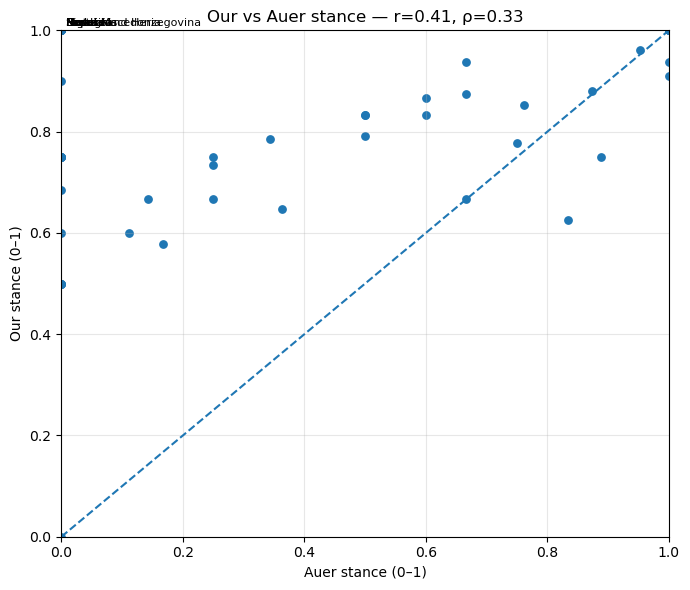

Saved ranked differences to compare_out\country_differences.csv

Agreement matrix (τ=0.5 cut):
our_bucket    cautious/opp  supportive
auer_bucket                           
cautious/opp             2          31
supportive               0          21

Robustness (n_speeches ≥ 10): N=14 — Pearson 0.842, Spearman 0.824, Kendall 0.648


48

In [19]:
# === Comparison of our stance vs Auer–Cornelli–Frost (country level) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

INFILE = "merged_cbdc_country_with_auer.csv"
OUTDIR = Path("compare_out"); OUTDIR.mkdir(exist_ok=True)

df = pd.read_csv(INFILE)

# keep overlap rows with both series
comp = df.copy()
# our stance in [0,1]
if "stance01_our" not in comp.columns and "mean_stance" in comp.columns:
    comp["stance01_our"] = (comp["mean_stance"] + 1) / 2.0

# pick Auer stance: prefer raw 0..1; fallback to min–max of normalized if needed
if "auer_stance_raw" in comp.columns and comp["auer_stance_raw"].notna().any():
    comp["stance_auer_use"] = pd.to_numeric(comp["auer_stance_raw"], errors="coerce")
elif "auer_stance_norm" in comp.columns and comp["auer_stance_norm"].notna().any():
    tmp = pd.to_numeric(comp["auer_stance_norm"], errors="coerce")
    comp["stance_auer_use"] = (tmp - tmp.min()) / (tmp.max() - tmp.min())
else:
    raise ValueError("No usable Auer stance column found.")

# Drop rows with missing values
comp = comp[np.isfinite(comp["stance01_our"]) & np.isfinite(comp["stance_auer_use"])].copy()

# Keep helpful labels
comp["country"] = comp["country_our"].fillna(comp["country_auer"])

# --------- 1) Correlations ----------
pear   = comp["stance01_our"].corr(comp["stance_auer_use"], method="pearson")
spear  = comp["stance01_our"].corr(comp["stance_auer_use"], method="spearman")
kend   = comp["stance01_our"].corr(comp["stance_auer_use"], method="kendall")

print(f"Overlap countries: {comp['country'].nunique()}")
print(f"Pearson  : {pear:.3f}")
print(f"Spearman : {spear:.3f}")
print(f"Kendall  : {kend:.3f}")

# Save a tiny summary
(Path(OUTDIR) / "summary.txt").write_text(
    f"Overlap countries: {comp['country'].nunique()}\n"
    f"Pearson : {pear:.3f}\n"
    f"Spearman: {spear:.3f}\n"
    f"Kendall : {kend:.3f}\n"
)

# --------- 2) Scatter with 45° reference and labels ----------
plt.figure(figsize=(7,6))
plt.scatter(comp["stance_auer_use"], comp["stance01_our"], s=28)
mn = 0; mx = 1
plt.plot([mn,mx],[mn,mx], linestyle="--")  # 45° line
plt.xlim(mn, mx); plt.ylim(mn, mx)
plt.xlabel("Auer stance (0–1)")
plt.ylabel("Our stance (0–1)")
plt.title(f"Our vs Auer stance — r={pear:.2f}, ρ={spear:.2f}")
# light labeling for most deviant points
comp["abs_diff"] = (comp["stance01_our"] - comp["stance_auer_use"]).abs()
for _, r in comp.sort_values("abs_diff", ascending=False).head(12).iterrows():
    plt.annotate(r["country"], (r["stance_auer_use"], r["stance01_our"]),
                 xytext=(3,3), textcoords="offset points", fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTDIR / "scatter_our_vs_auer.png", dpi=220)
plt.show()

# --------- 3) Rank countries by difference ----------
rank = (comp[["country","stance01_our","stance_auer_use","n_speeches","pro_share","wait_share","anti_share"]]
        .assign(diff=lambda d: d["stance01_our"] - d["stance_auer_use"],
                abs_diff=lambda d: d["diff"].abs())
        .sort_values("abs_diff", ascending=False))

rank.to_csv(OUTDIR / "country_differences.csv", index=False)
print(f"Saved ranked differences to {OUTDIR/'country_differences.csv'}")

# --------- 4) Simple agreement matrix (threshold can be tuned) ----------
THR_OUR  = 0.5
THR_AUER = 0.5

comp["our_bucket"]  = np.where(comp["stance01_our"]  >= THR_OUR, "supportive", "cautious/opp")
comp["auer_bucket"] = np.where(comp["stance_auer_use"]>= THR_AUER, "supportive", "cautious/opp")

cmat = (comp.groupby(["auer_bucket","our_bucket"]).size()
          .rename("n").reset_index()
          .pivot(index="auer_bucket", columns="our_bucket", values="n").fillna(0).astype(int))

print("\nAgreement matrix (τ=0.5 cut):")
print(cmat)

cmat.to_csv(OUTDIR / "agreement_matrix.csv")

# --------- 5) (Optional) Robustness: restrict to countries with >= K speeches ----------
K = 10
rob = comp[comp["n_speeches"] >= K].copy()
pear_k   = rob["stance01_our"].corr(rob["stance_auer_use"], method="pearson") if len(rob) else np.nan
spear_k  = rob["stance01_our"].corr(rob["stance_auer_use"], method="spearman") if len(rob) else np.nan
kend_k   = rob["stance01_our"].corr(rob["stance_auer_use"], method="kendall") if len(rob) else np.nan
print(f"\nRobustness (n_speeches ≥ {K}): N={len(rob)} — Pearson {pear_k:.3f}, Spearman {spear_k:.3f}, Kendall {kend_k:.3f}")
(Path(OUTDIR) / f"robust_nge{K}.txt").write_text(
    f"N={len(rob)}\nPearson {pear_k:.3f}\nSpearman {spear_k:.3f}\nKendall {kend_k:.3f}\n"
)
